In [2]:
import sys
sys.path.append("..")
from webapp.utils.azure_utils import KeyVault, DataLake
from copy import deepcopy
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import MultiNormalizer, TorchNormalizer, EncoderNormalizer, GroupNormalizer
from pytorch_forecasting.metrics import MultiLoss, RMSE, MASE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from sklearn.preprocessing import StandardScaler
import torch

c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# Check Cuda Availability: 
torch.cuda.is_available()

True

In [5]:
# Connect to Storage Account:
vault = KeyVault(keyVaultName = "keyvaultdva2022")
storage_credential = vault.get_secret(secretName = "storagePrimaryKey")
storage = DataLake(account_name = "storageaccountdva", credential = storage_credential)
file_system = "energyhub"

In [6]:
# Read files and pick a site to model:
site = "Gator"
directory = f"forecasting/data/{site}"
train = storage.pandas_read(file_system, directory=directory, file_name=f"train.parq")
val = storage.pandas_read(file_system, directory=directory, file_name=f"val.parq")

In [7]:
train.shape

(787440, 24)

In [8]:
val.shape

(196898, 24)

In [9]:
# Fix dtypes:
train.cloud_coverage = train.cloud_coverage.astype("str").astype("category")
val.cloud_coverage = val.cloud_coverage.astype("str").astype("category")

In [10]:
# Create dataset for modelling:
days_test = 3
test_lengths = 24 * days_test
days_prediction = 7
max_prediction_length = 24 * days_prediction

training = TimeSeriesDataSet(
    data = train, # Training dataset
    time_idx = "time_idx",
    target = "electricity", # Targets to predict
    group_ids=["building_id"],
    max_encoder_length = test_lengths,
    min_encoder_length = 24,
    max_prediction_length = max_prediction_length,  
    min_prediction_length = 24,
    static_categoricals = ["building_id"], # List of categorical variables that do not change over time
    static_reals = ["sq_meter"], # List of continuous variables that do not change over time
    time_varying_known_categoricals = [], # List of categorical variables that change over time and are known in the future
    variable_groups = {},  # Group of categorical variables can be treated as one variable
    time_varying_known_reals = ['time_idx', 'time_norm', 'cos_time', 'sin_time', 'month_cos', 'month_sin',
       'weekday_cos', 'weekday_sin', 'air_temperature', 'cloud_coverage', 
    'dew_temperature','precipitation_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'], # List of categorical variables that change over time and are known in the future
    time_varying_unknown_categoricals = [], # List of categorical variables that change over time and are not known in the future
    time_varying_unknown_reals = ['electricity'], # List of continuous variables that change over time and are known in the future
    target_normalizer = GroupNormalizer(
        groups=["building_id"], transformation="softplus"),
    add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True,
    allow_missing_timesteps = True
)


In [10]:
# Create validation/test dataset:
validation = TimeSeriesDataSet.from_dataset(training, val, predict = True, stop_randomization = True)

# Data Loaders:
batch_size = 128
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size * 10, num_workers = 0)

In [11]:
# Network and Trainer Configuration:
pl.seed_everything(43) # Set seed
trainer = pl.Trainer(
    gpus = 1,
    gradient_clip_val=0.02,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.02,
    hidden_size = 64,
    lstm_layers = 2,
    attention_head_size = 1,
    dropout = 0.1,
    hidden_continuous_size = 48,
    output_size = 1,  
    loss = RMSE(),
    reduce_on_plateau_patience = 4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 43
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 732.4k


In [12]:
# Configure Logging and Trainier:
early_stop_callback = EarlyStopping(monitor = "val_loss", min_delta = 1e-4, 
                                    patience = 10, verbose = True, mode = "min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs", name = "tft", log_graph = True)  # logging results to a tensorboard

# tensorboard --logdir=lightning_logs, run this command to load tensorboard

trainer = pl.Trainer(
    max_epochs = 30,
    gpus = 1,
    weights_summary = "top",
    gradient_clip_val = 0.03,
    limit_train_batches = 1024,  # Commet during training
    #fast_dev_run = True,
    callbacks = [lr_logger, early_stop_callback],
    logger = logger
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [14]:
# Fit Model:
trainer.fit(
    tft,
    train_dataloader = train_dataloader,
    val_dataloaders = val_dataloader,
)

c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\loggers\tensorboard.py:247: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  rank_zero_warn(

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList              

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 43
c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 1025/1025 [12:09<00:00,  1.41it/s, loss=48.4, v_num=18, train_loss_step=30.50, val_loss=51.00]

Metric val_loss improved. New best score: 51.027


Epoch 2: 100%|██████████| 1025/1025 [12:08<00:00,  1.41it/s, loss=45.3, v_num=18, train_loss_step=62.00, val_loss=49.00, train_loss_epoch=48.60]

Metric val_loss improved by 2.048 >= min_delta = 0.0001. New best score: 48.979


Epoch 3: 100%|██████████| 1025/1025 [12:11<00:00,  1.40it/s, loss=39.8, v_num=18, train_loss_step=37.80, val_loss=39.40, train_loss_epoch=45.00]

Metric val_loss improved by 9.548 >= min_delta = 0.0001. New best score: 39.431


Epoch 4: 100%|██████████| 1025/1025 [12:12<00:00,  1.40it/s, loss=38.3, v_num=18, train_loss_step=51.70, val_loss=39.00, train_loss_epoch=41.80]

Metric val_loss improved by 0.417 >= min_delta = 0.0001. New best score: 39.014


Epoch 14:  60%|█████▉    | 611/1025 [07:25<05:01,  1.37it/s, loss=19.6, v_num=18, train_loss_step=19.60, val_loss=47.20, train_loss_epoch=20.70] 

c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [15]:
# Load best model:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [16]:
# Calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions,x,index,decoder_lengths = best_tft.predict(val_dataloader,return_x=True,return_index = True,return_decoder_lengths=True)

In [ ]:
predictions.shape

torch.Size([98, 168])

In [17]:
rmse = torch.round(((predictions - actuals)**2).mean(dim = 1).sqrt(), decimals = 2)

In [18]:
rmse.mean()

tensor(14.6075)

In [19]:
predictions.shape

torch.Size([64, 168])

In [20]:
n = actuals.shape[0]
buildings = index.building_id

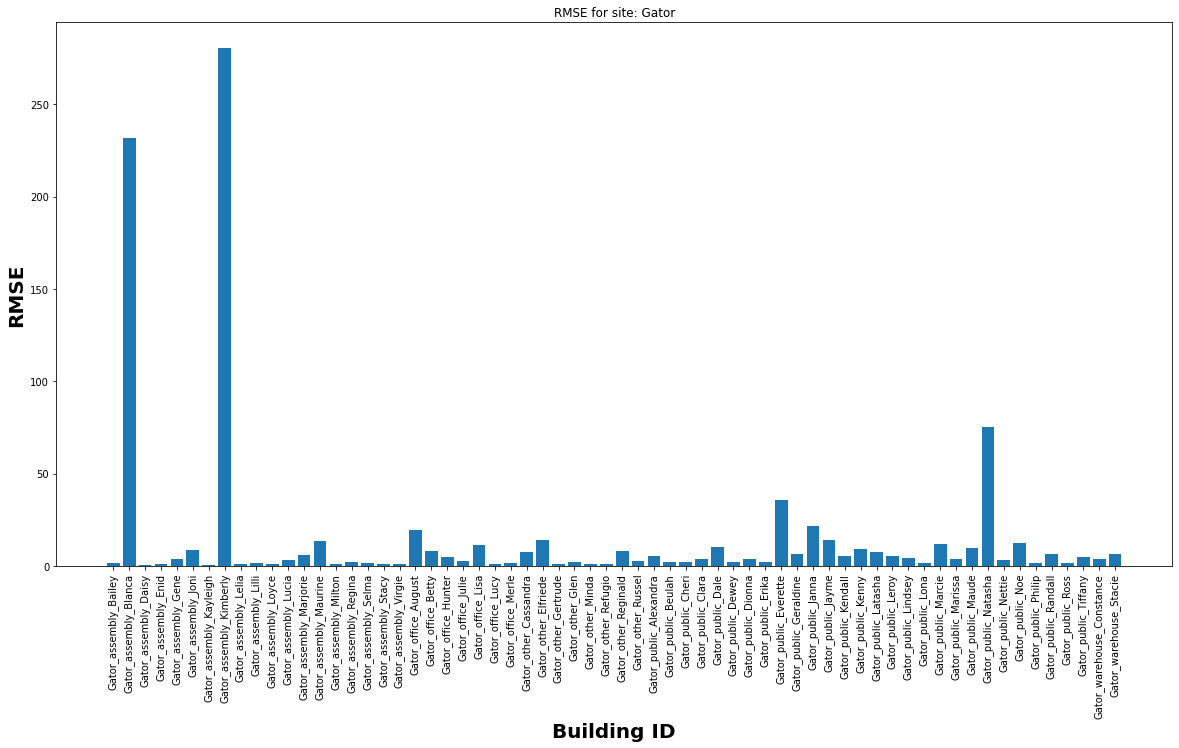

In [21]:
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(buildings, rmse)
ax.set_xlabel('Building ID', fontsize=20, fontweight='bold')
ax.set_ylabel('RMSE', fontsize=20, fontweight='bold')
ax.set_title(f"RMSE for site: {site}") 
plt.xticks(rotation = 90);

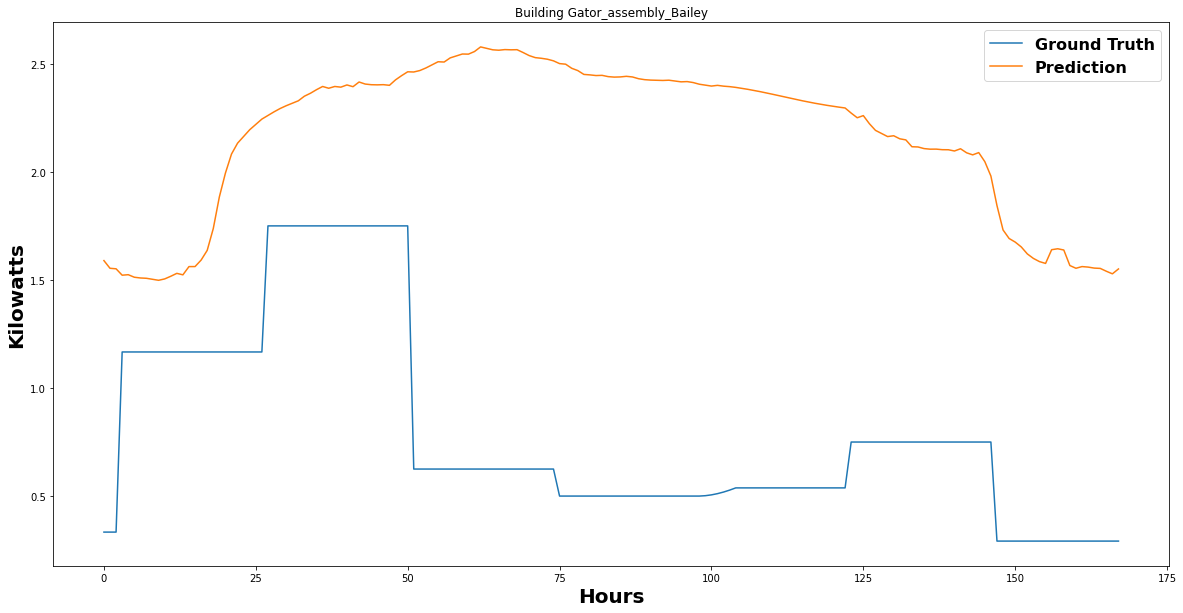

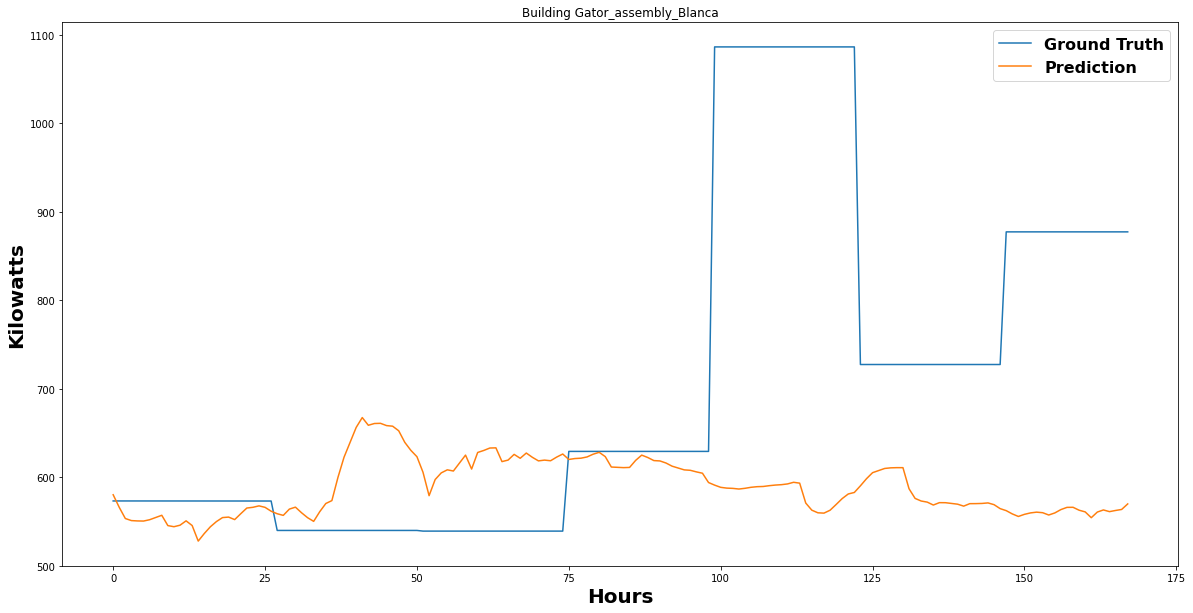

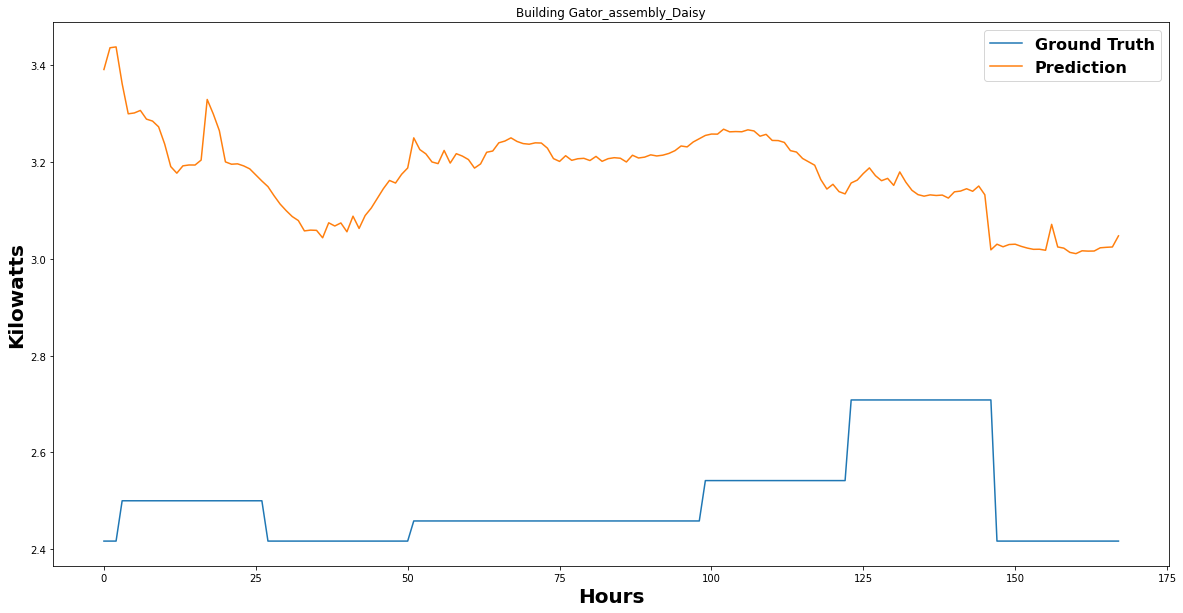

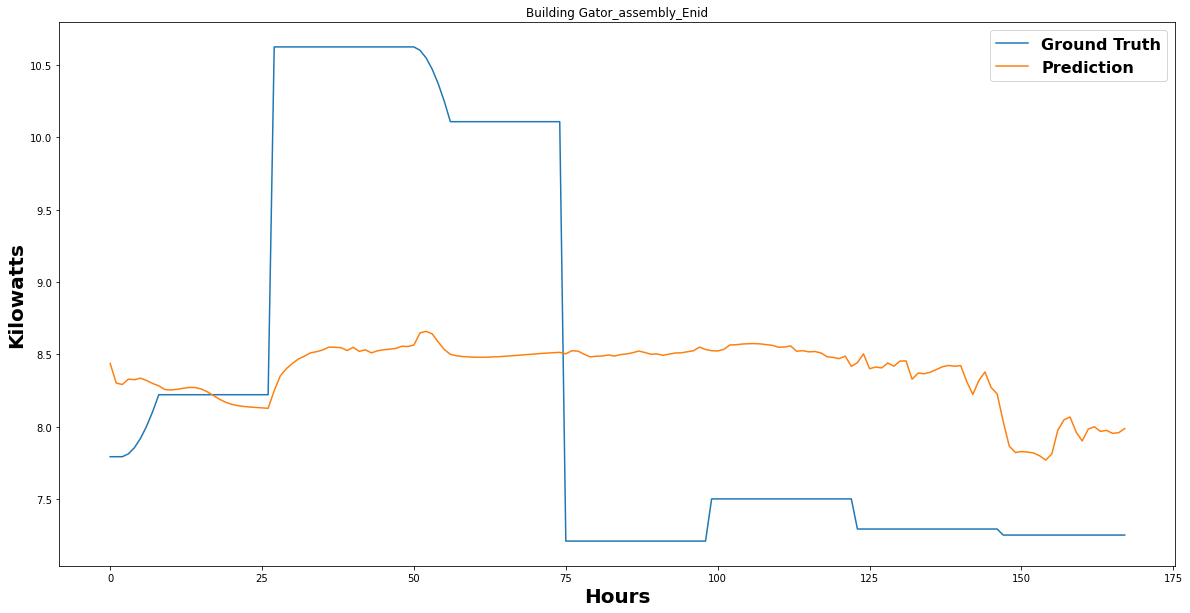

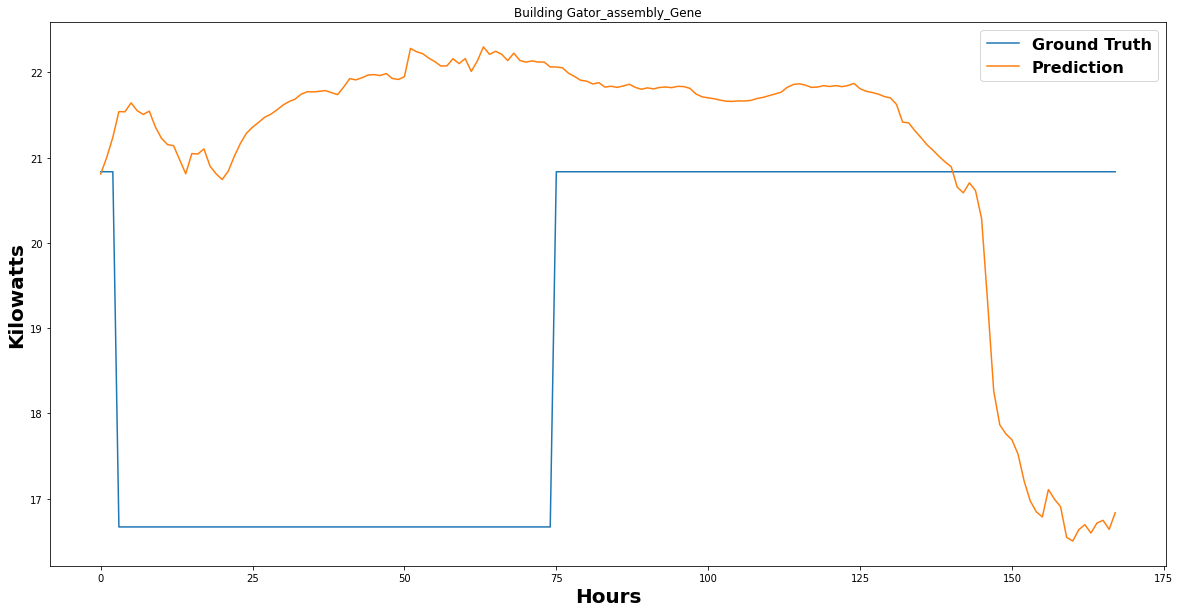

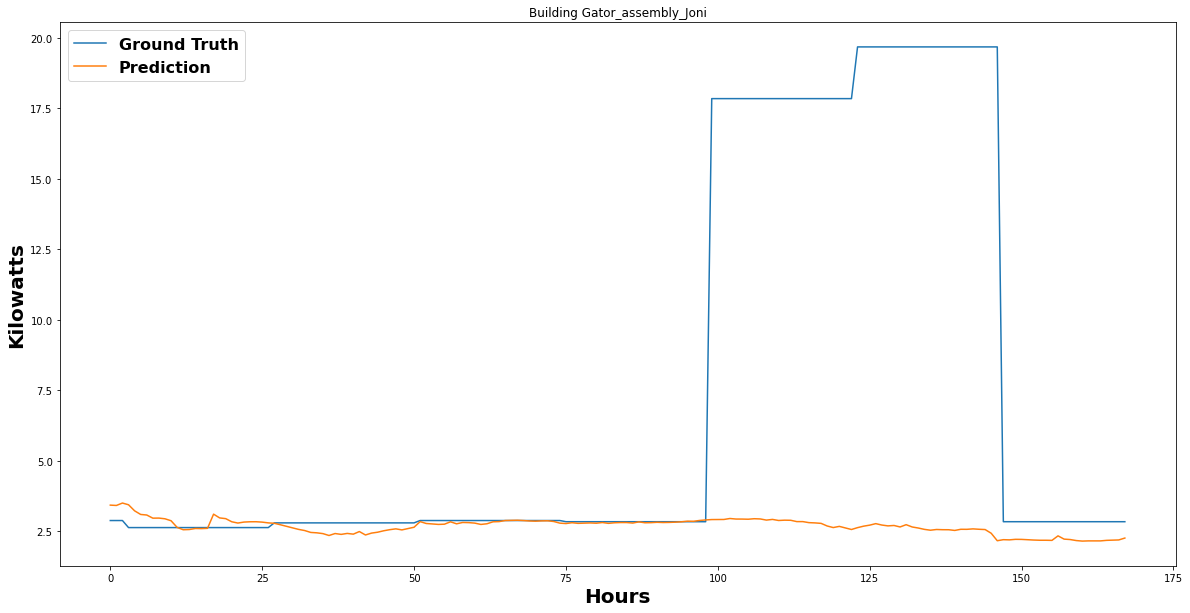

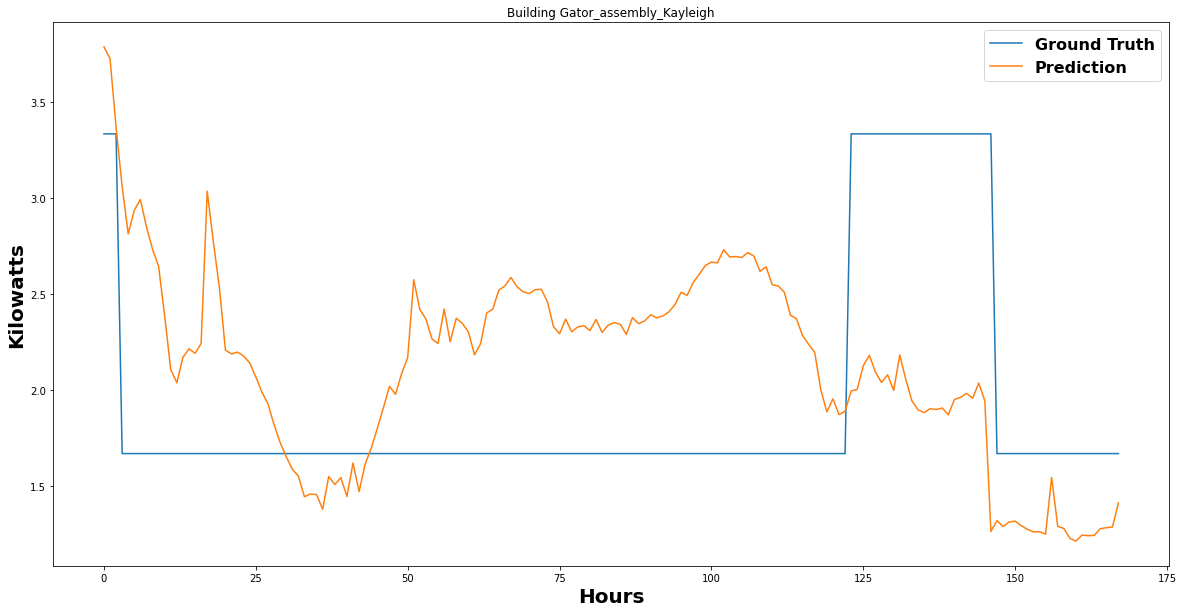

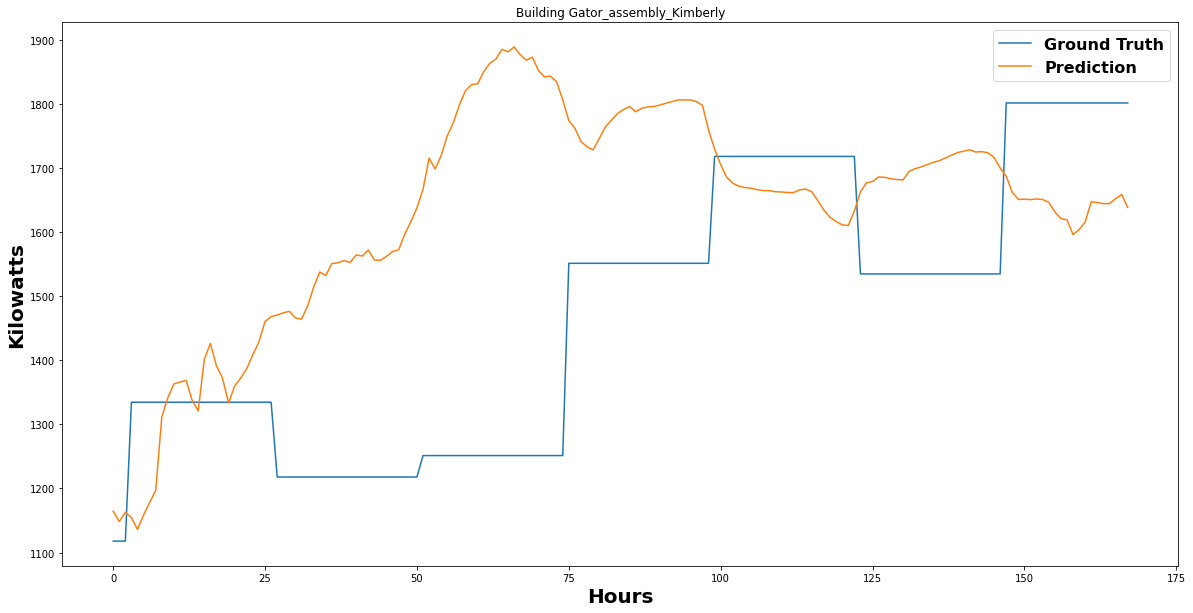

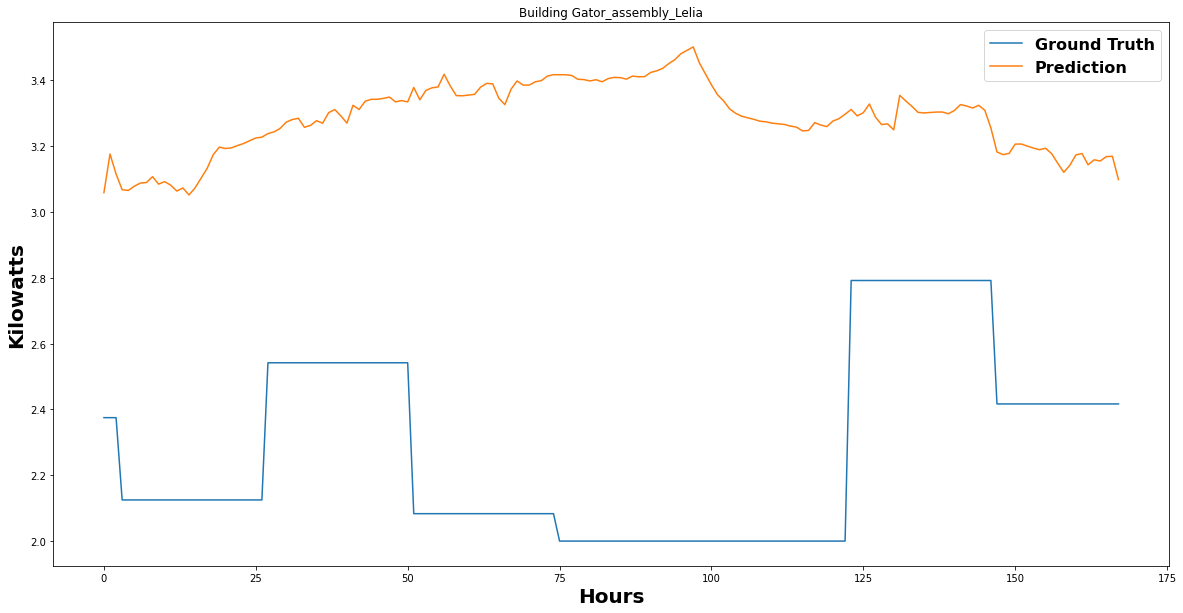

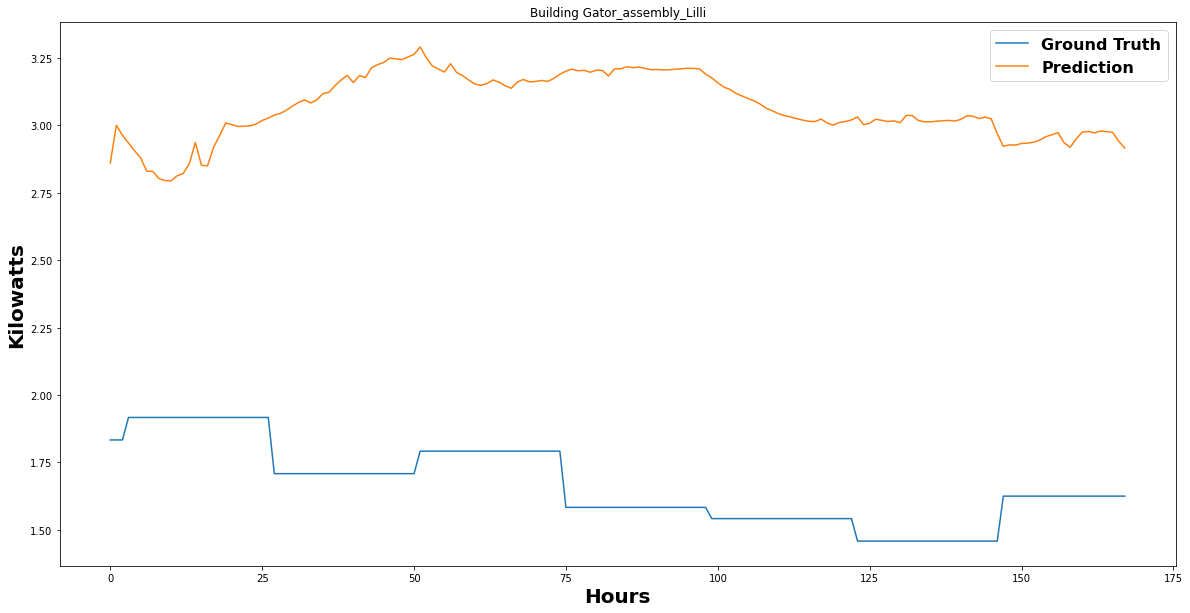

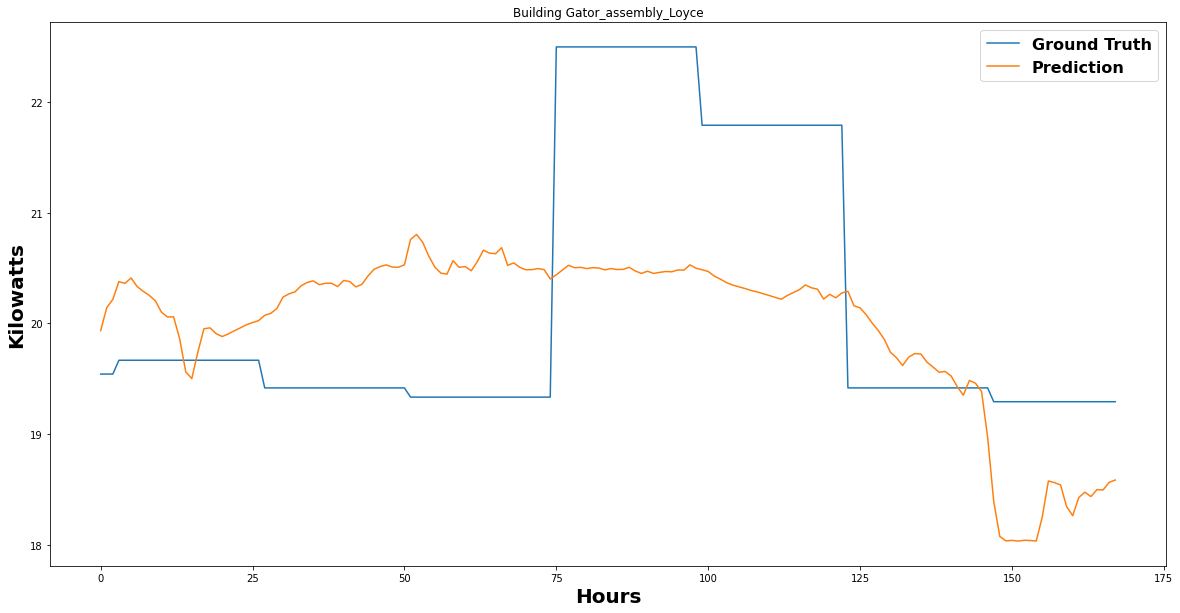

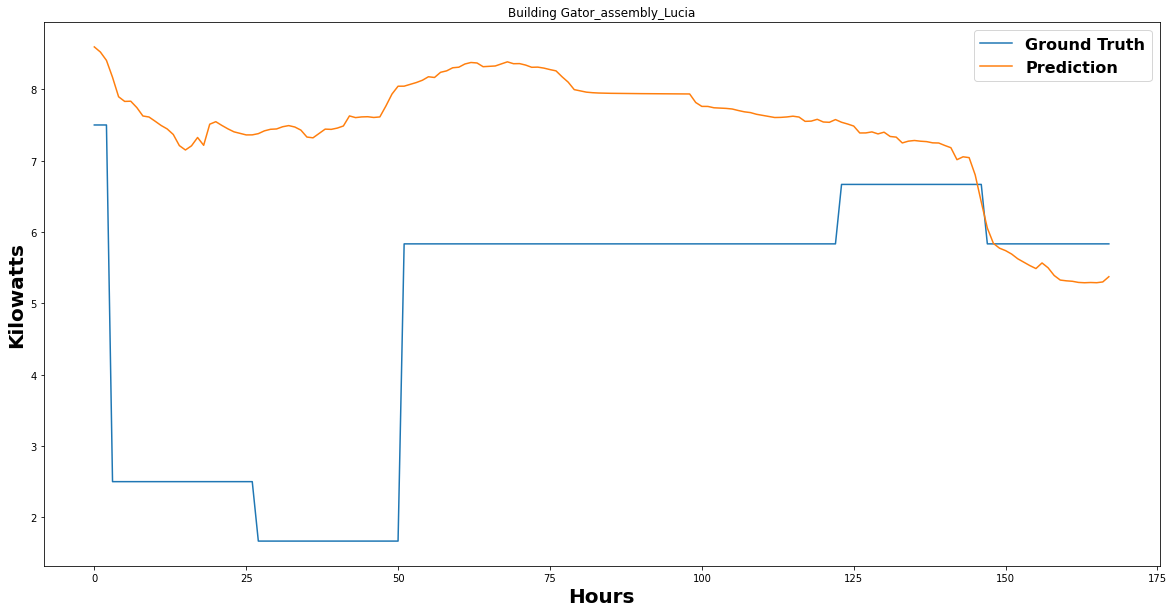

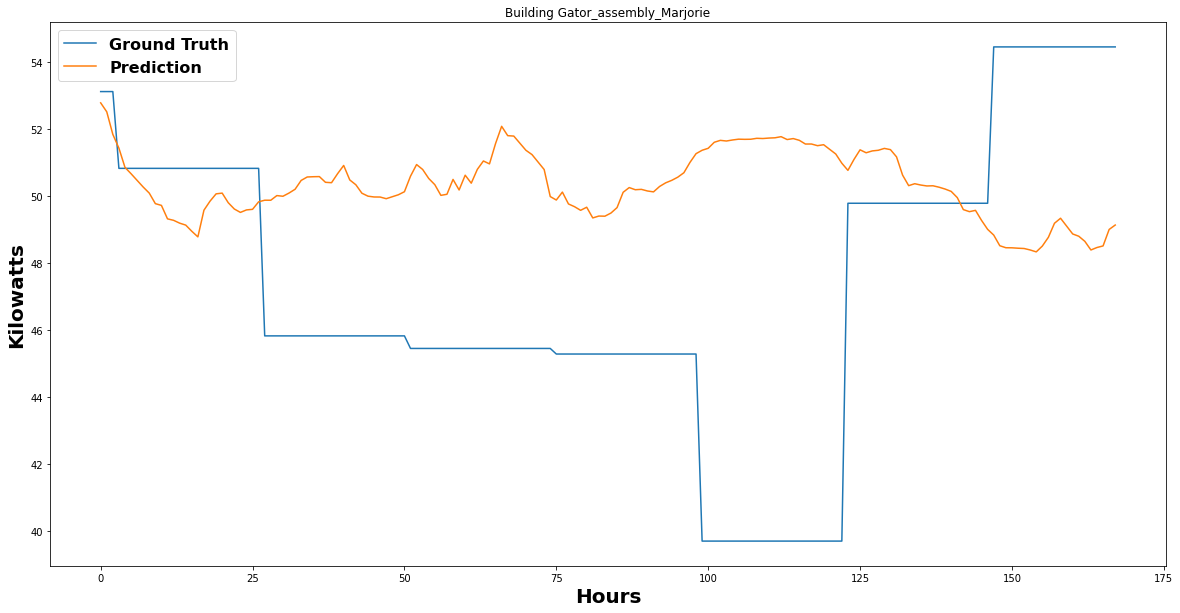

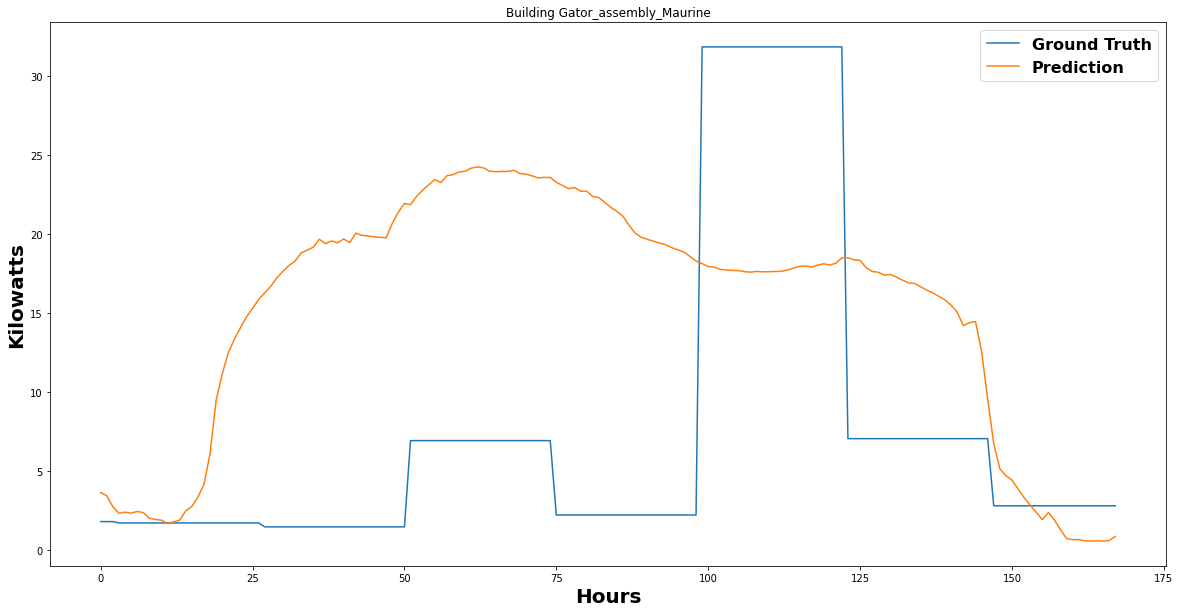

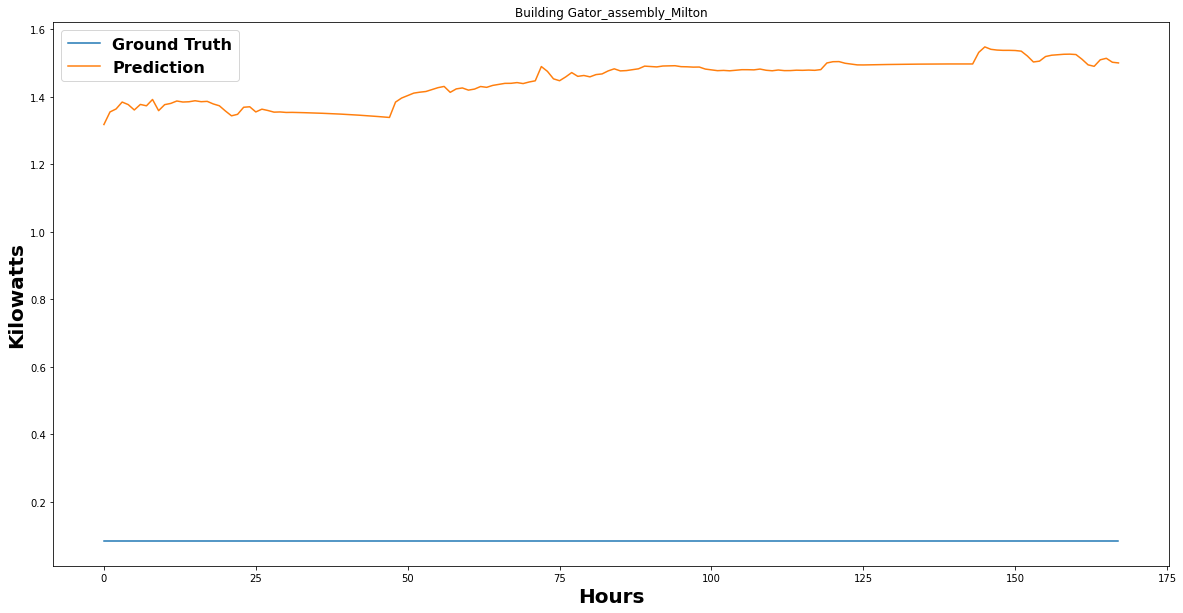

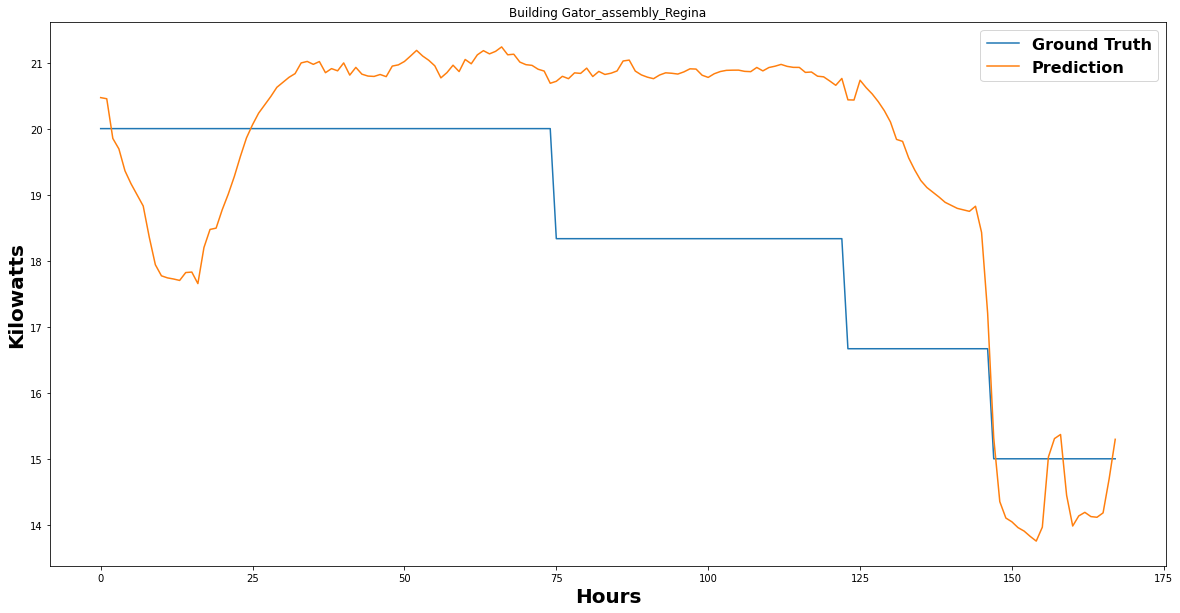

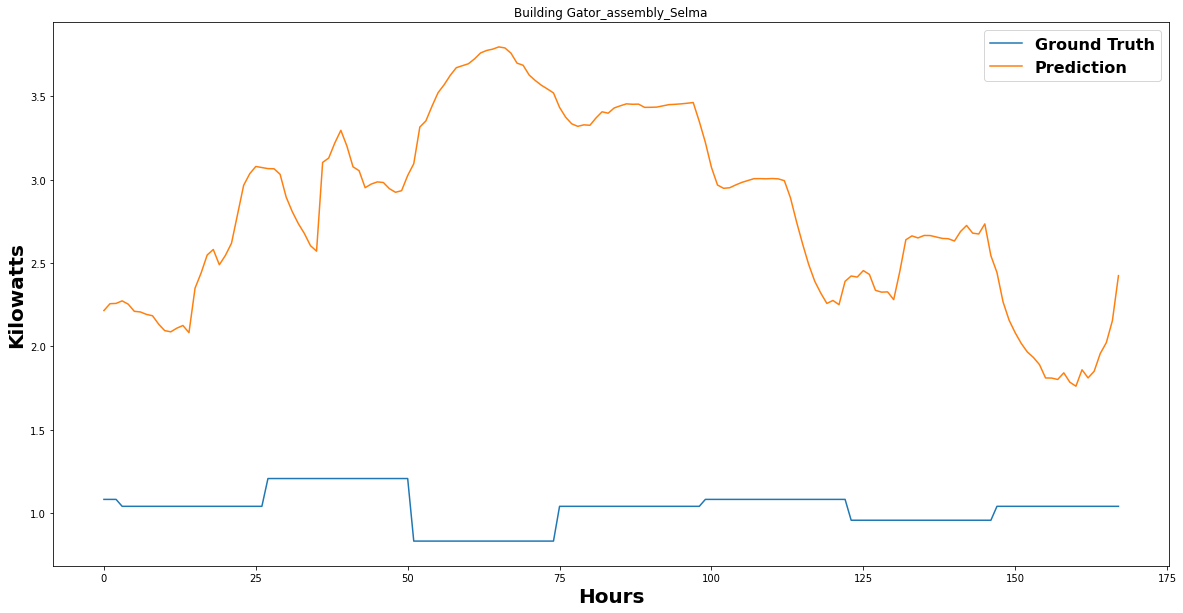

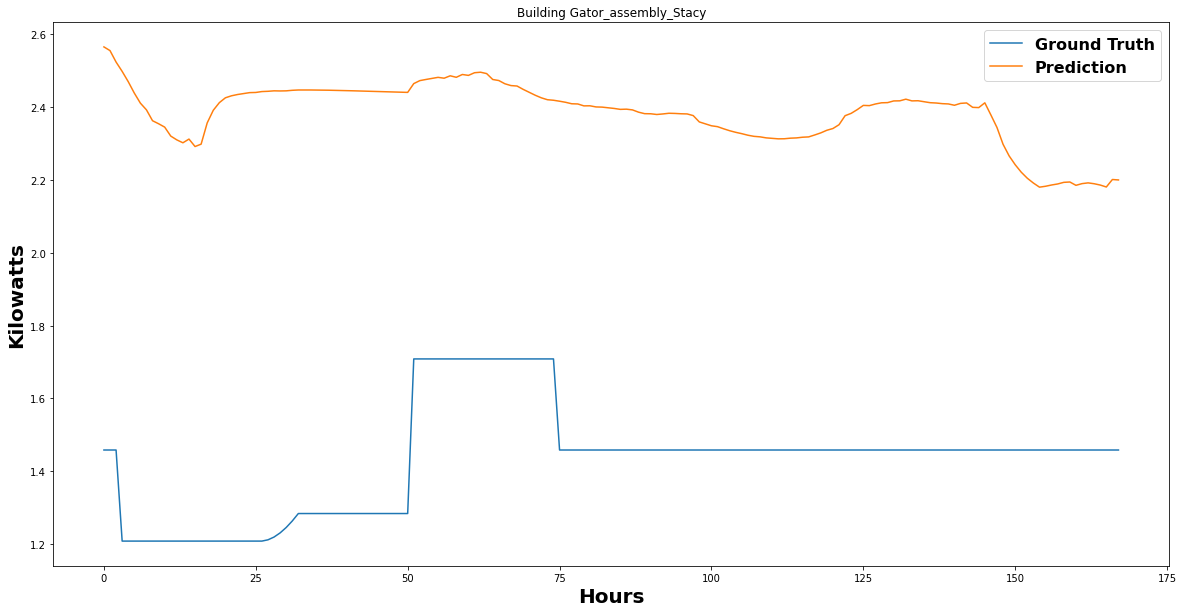

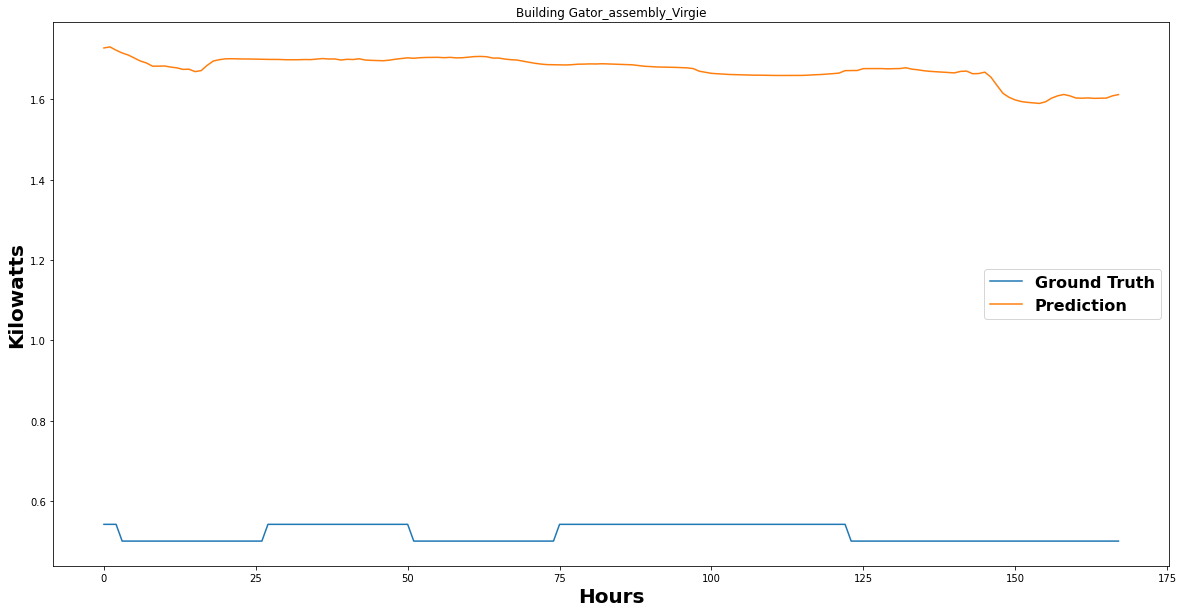

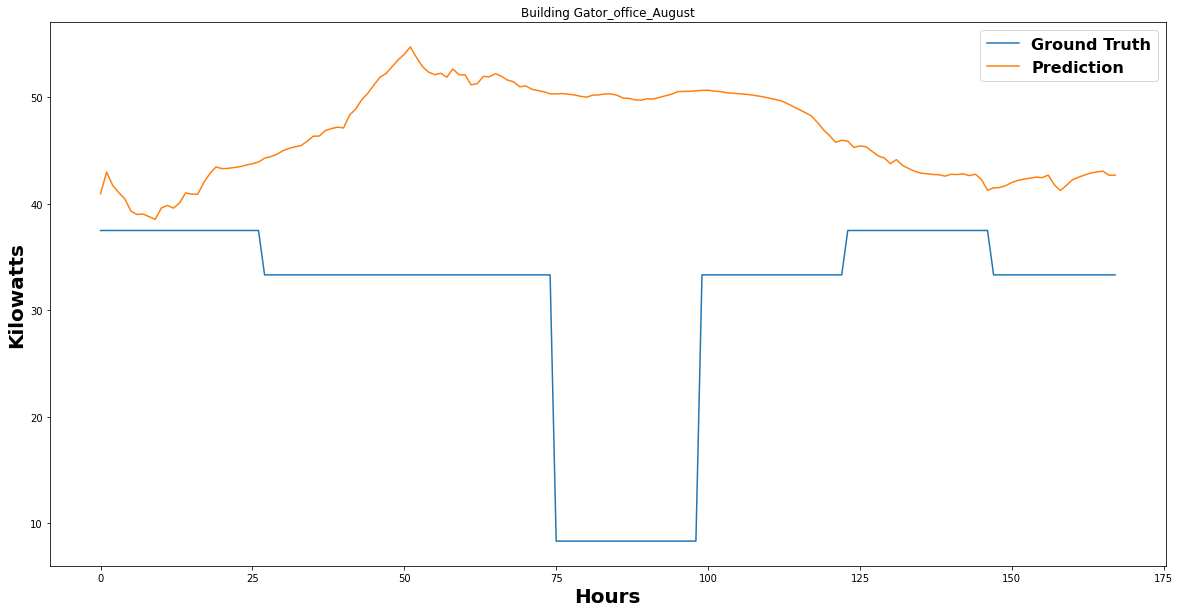

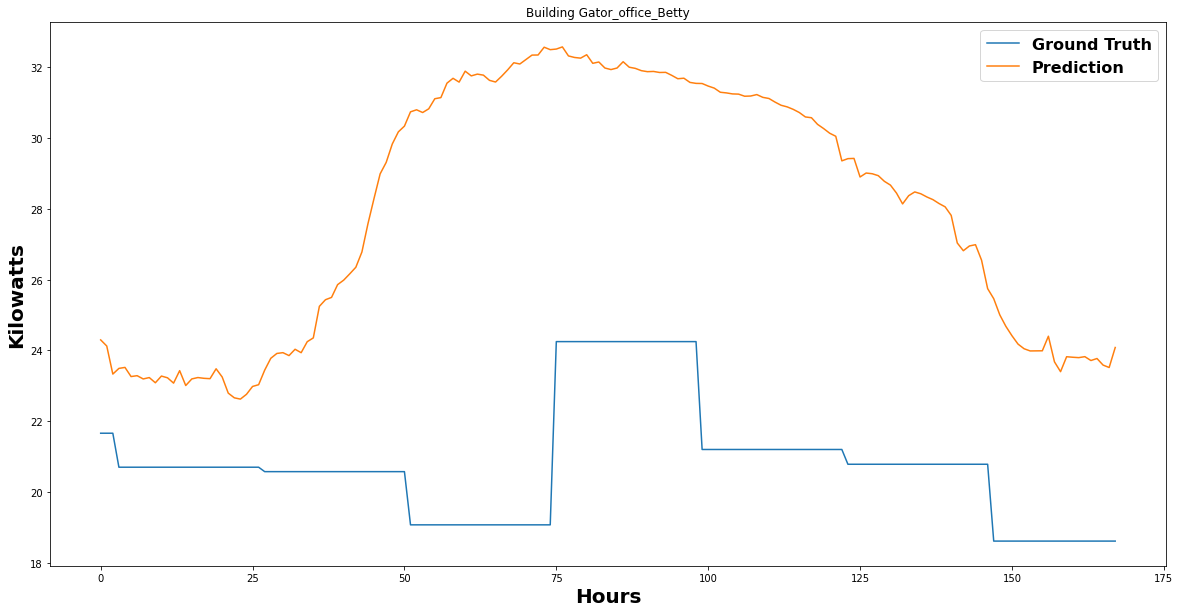

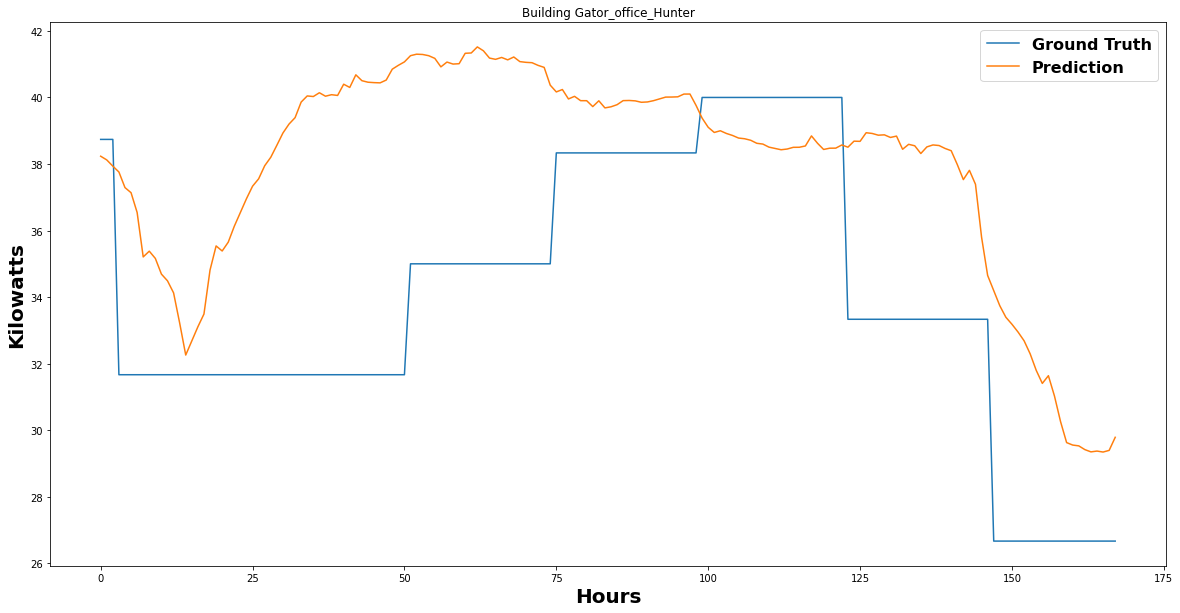

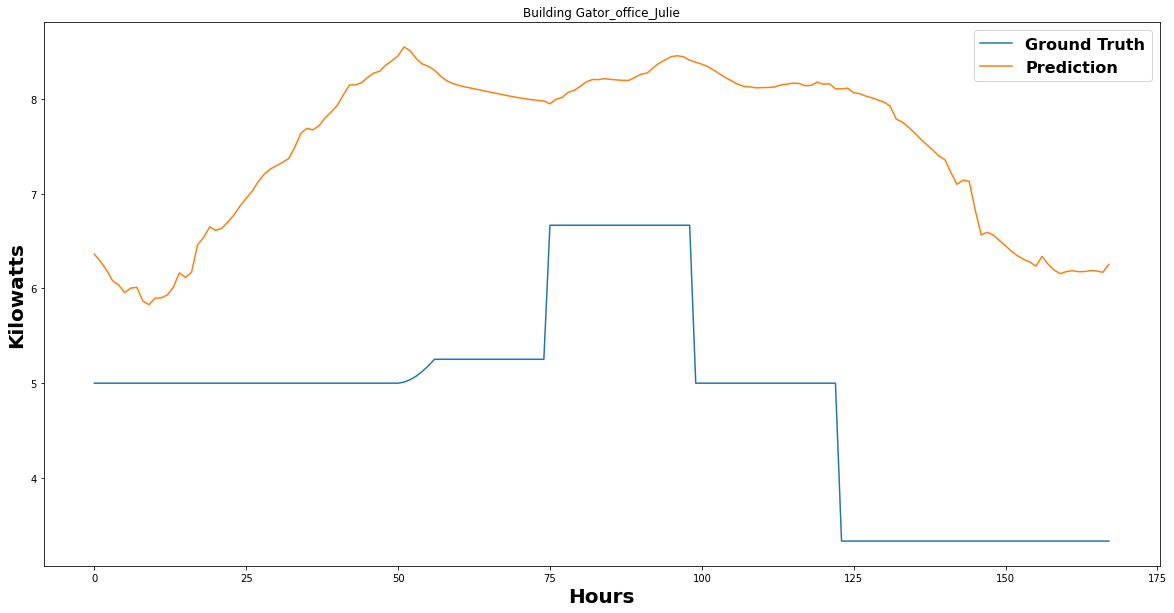

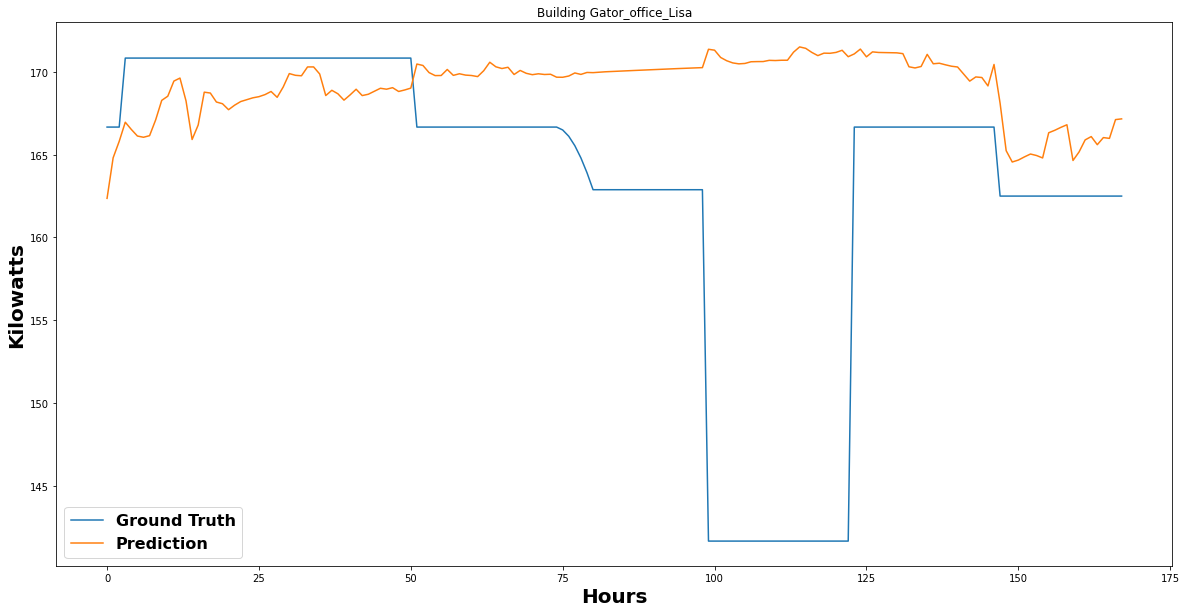

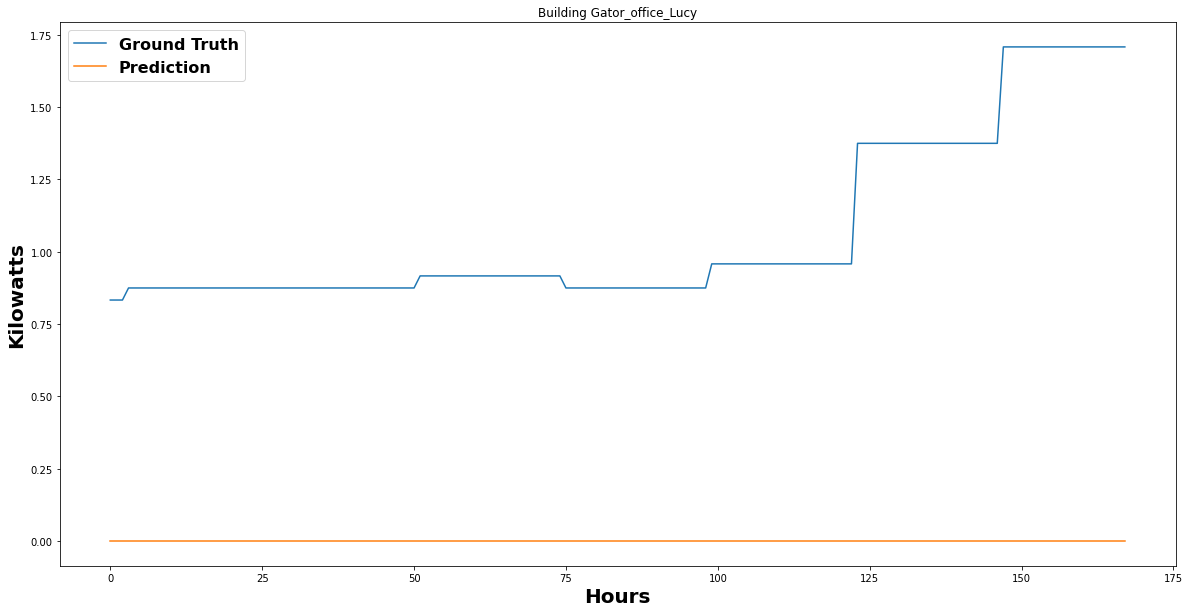

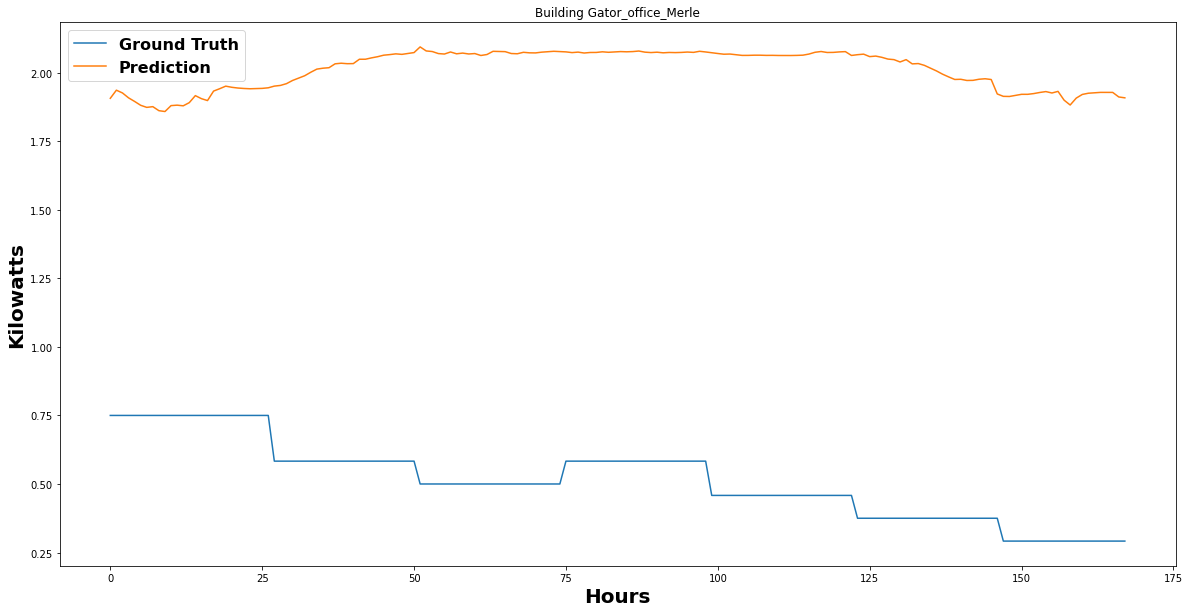

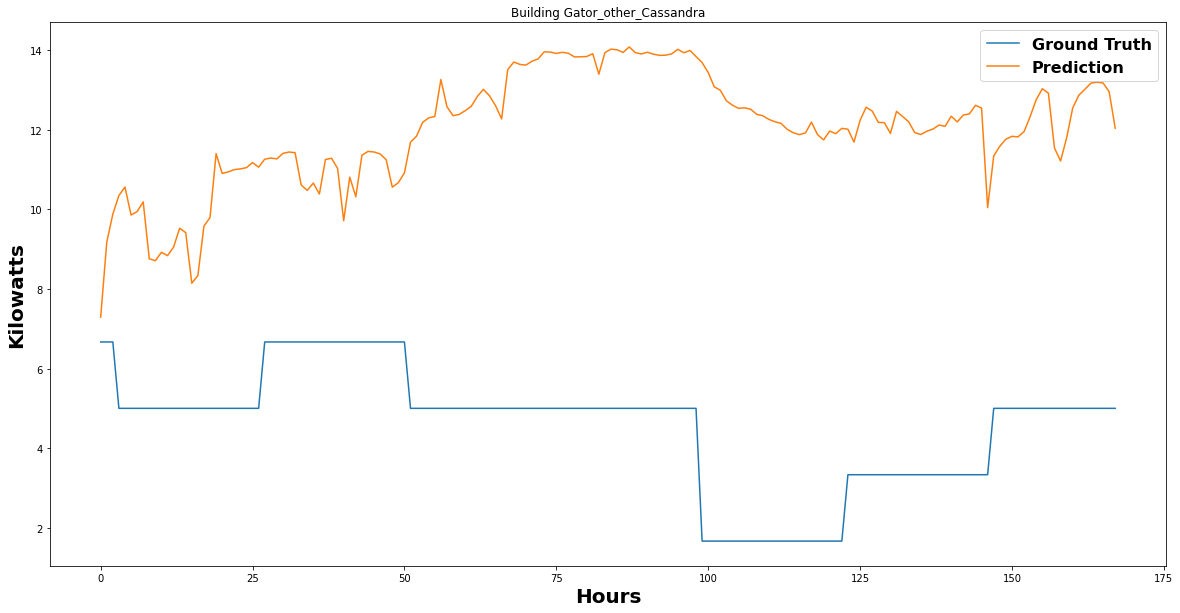

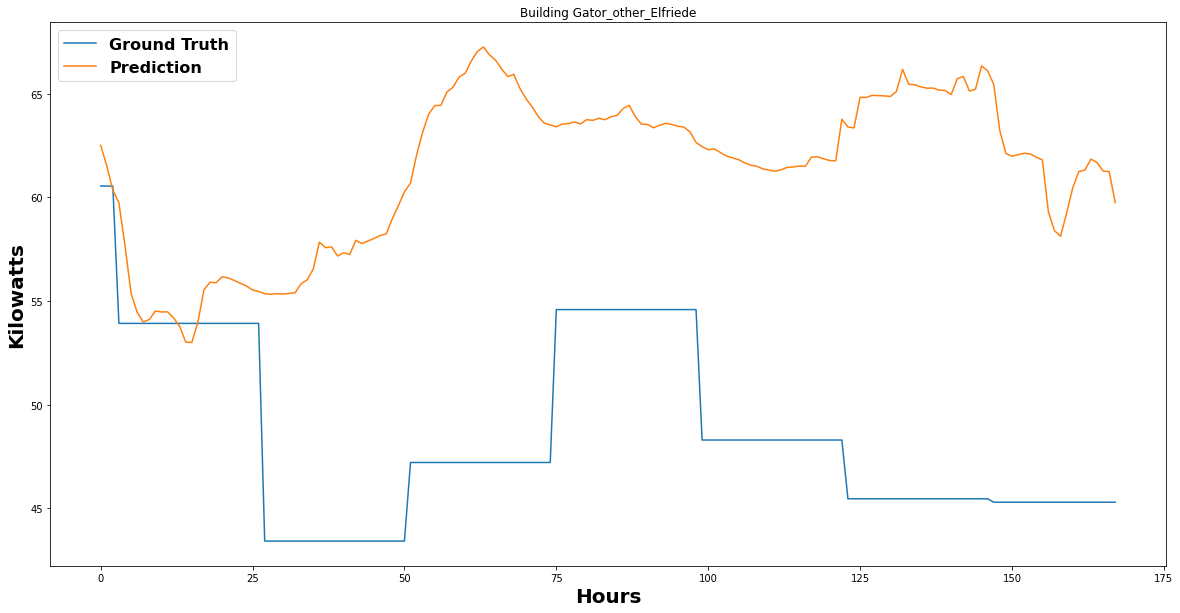

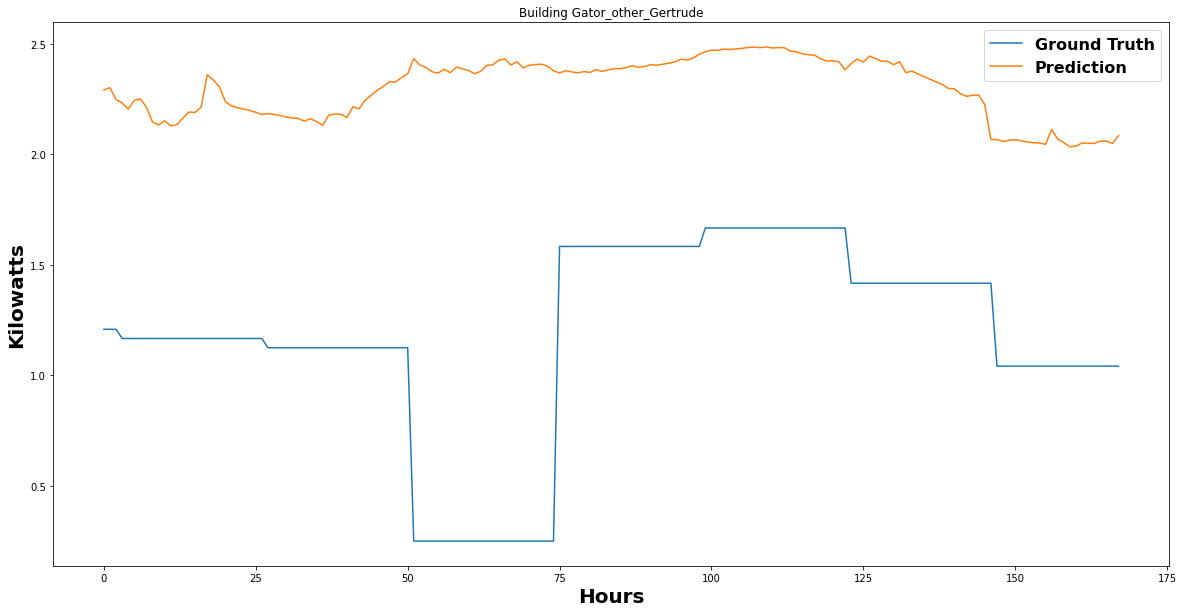

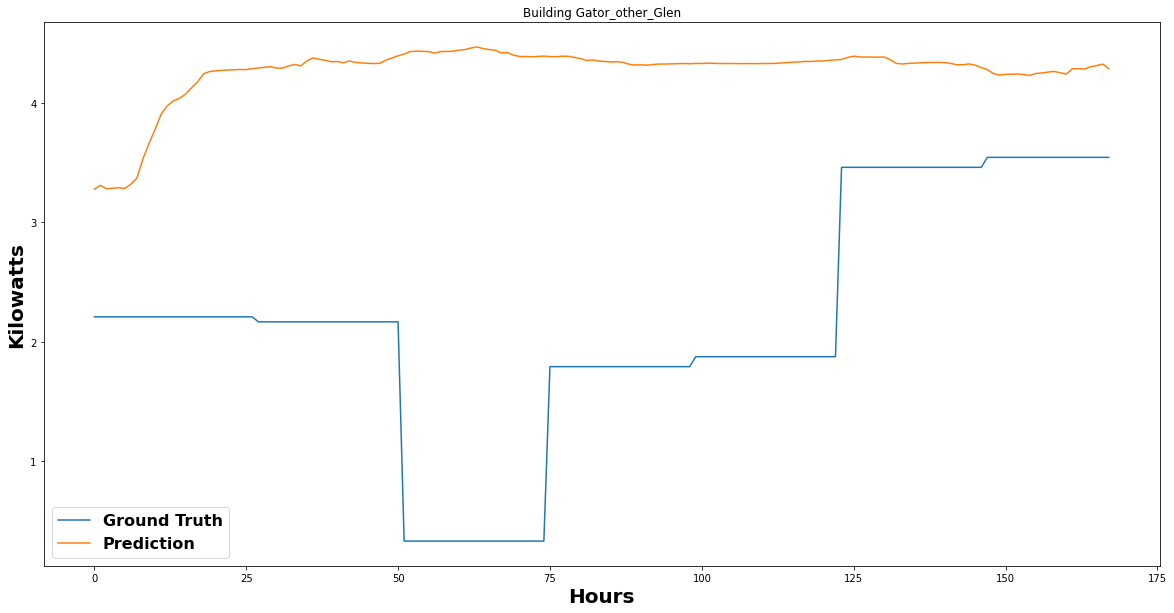

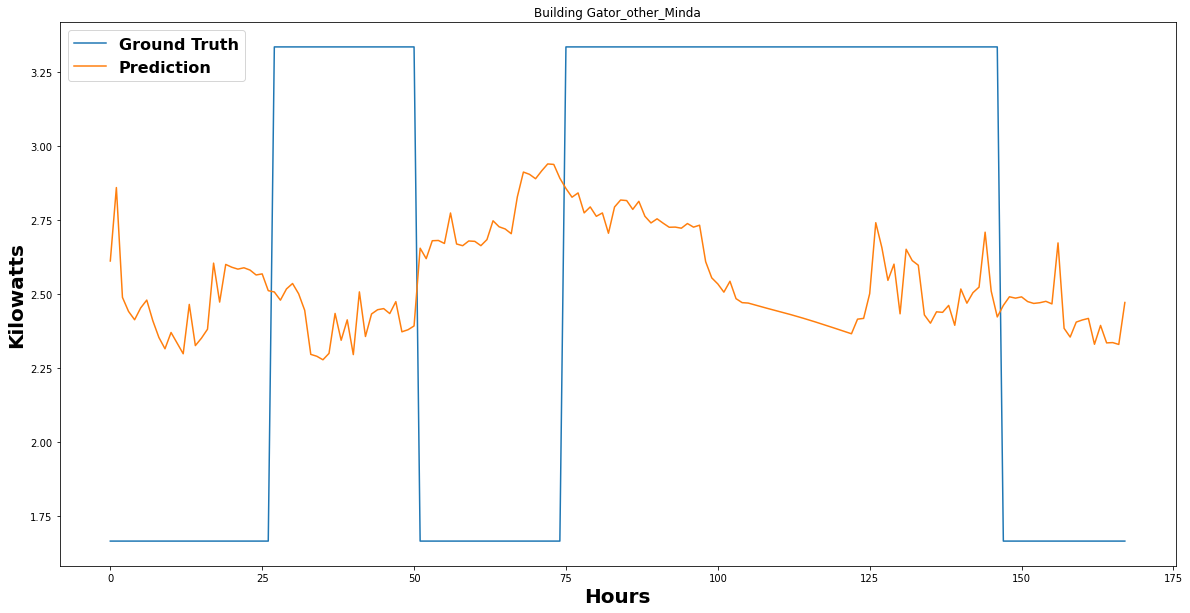

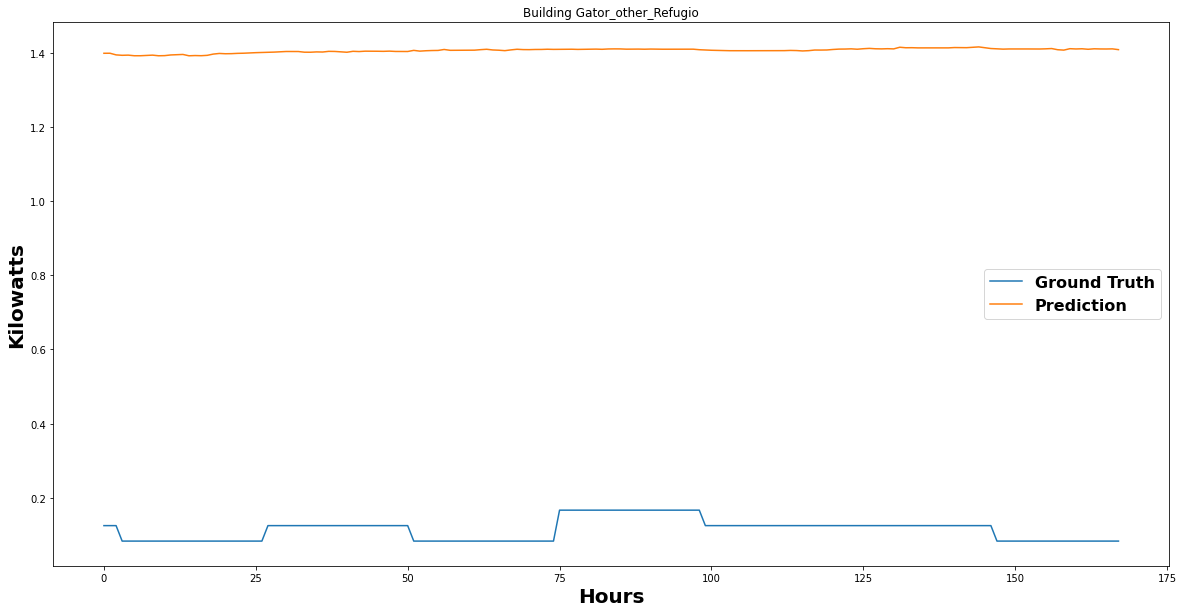

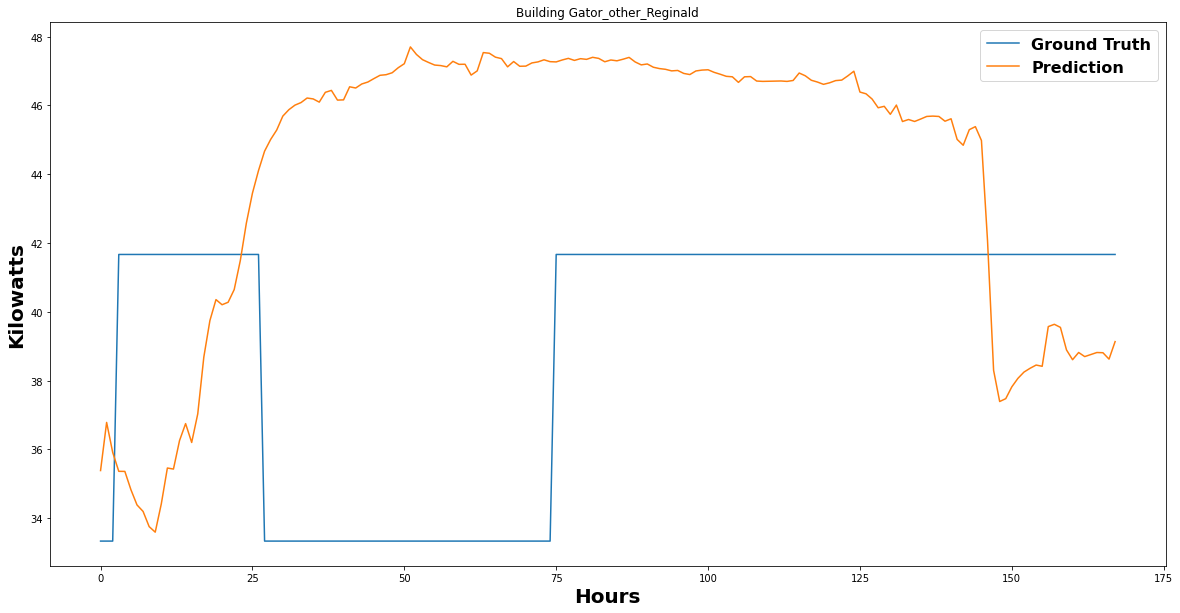

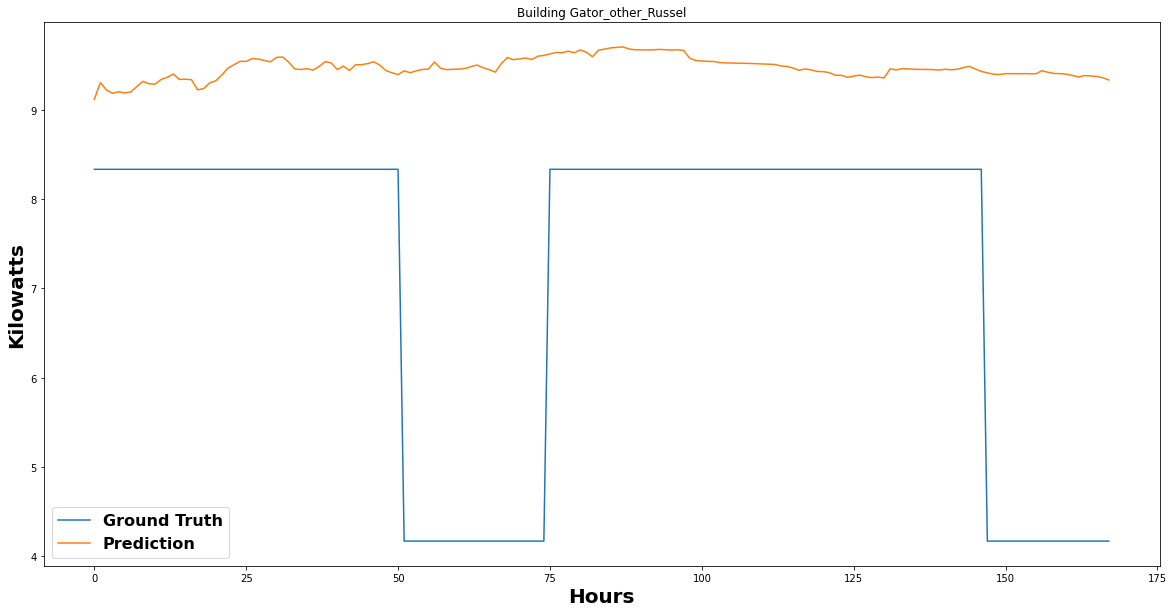

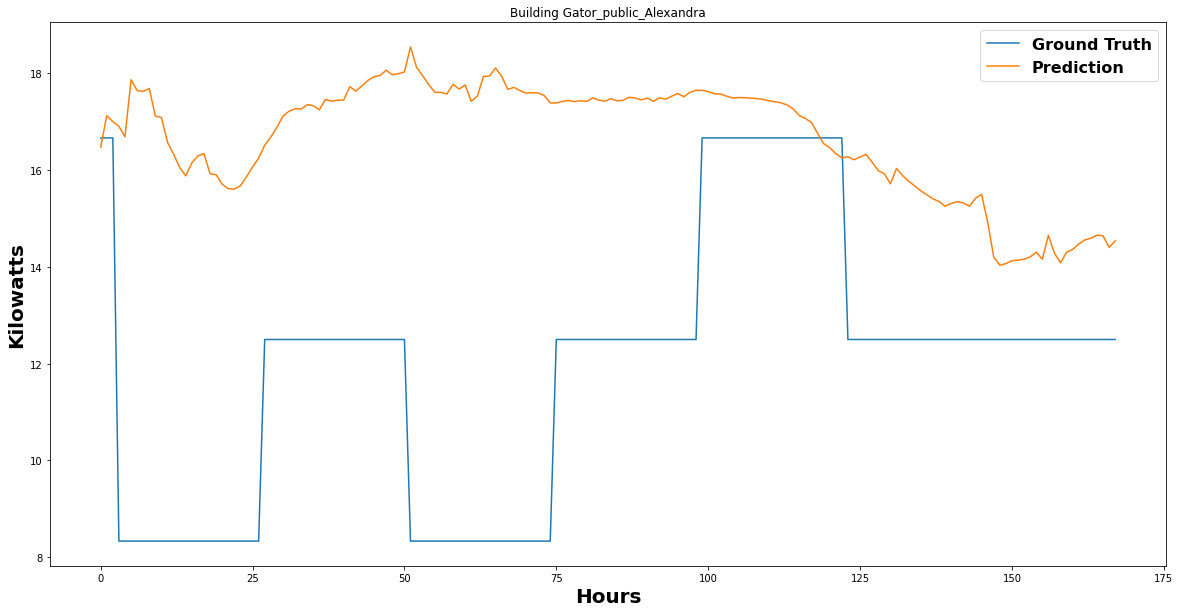

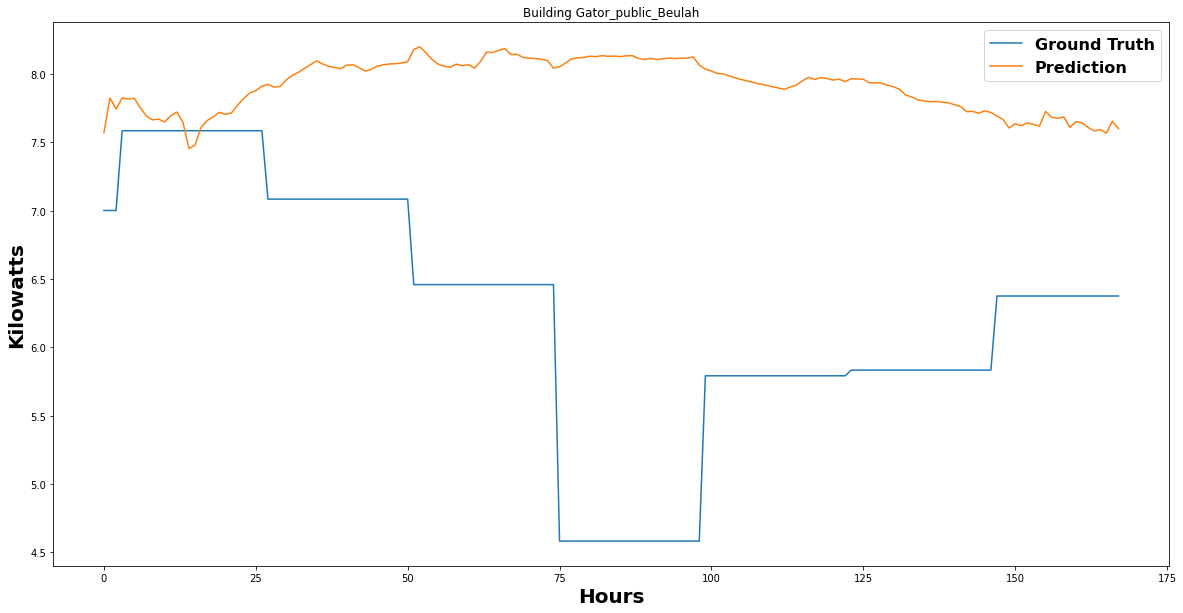

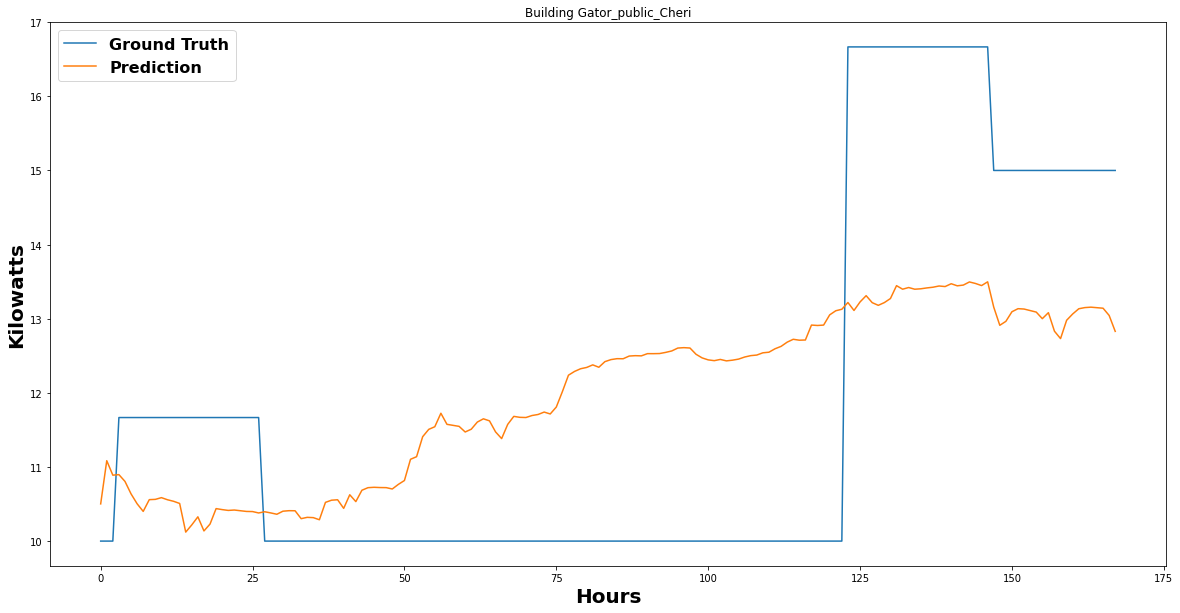

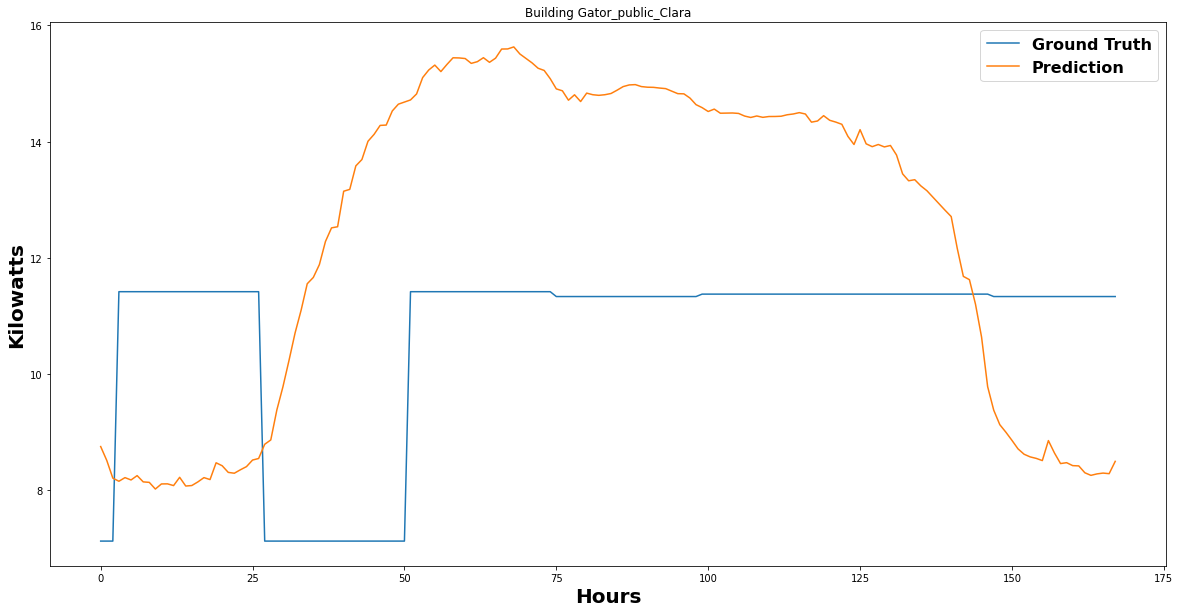

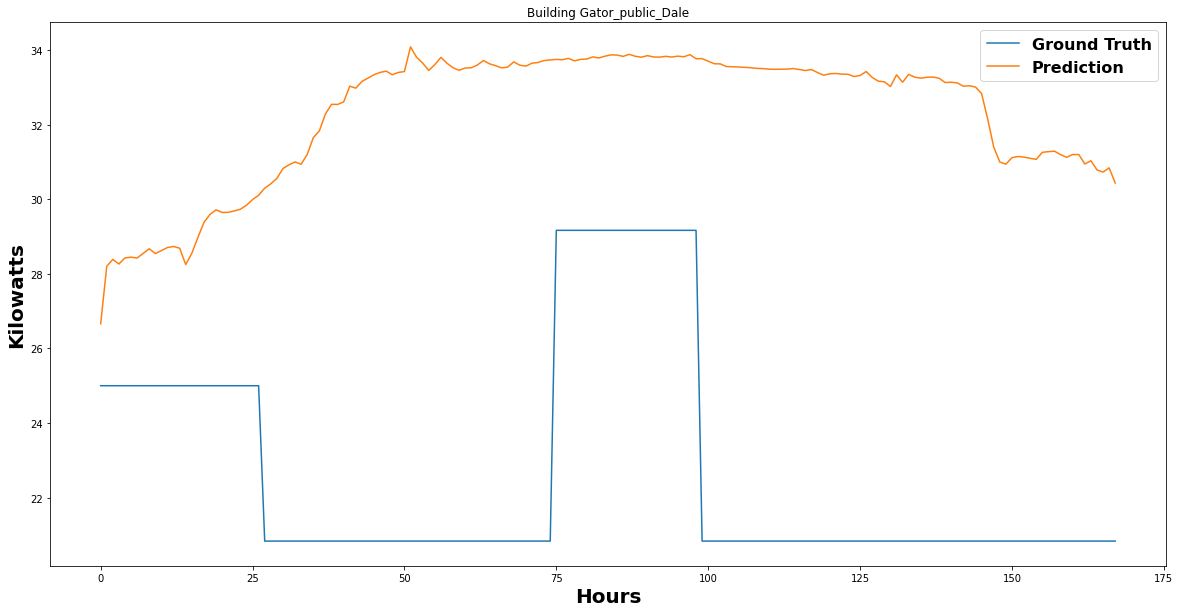

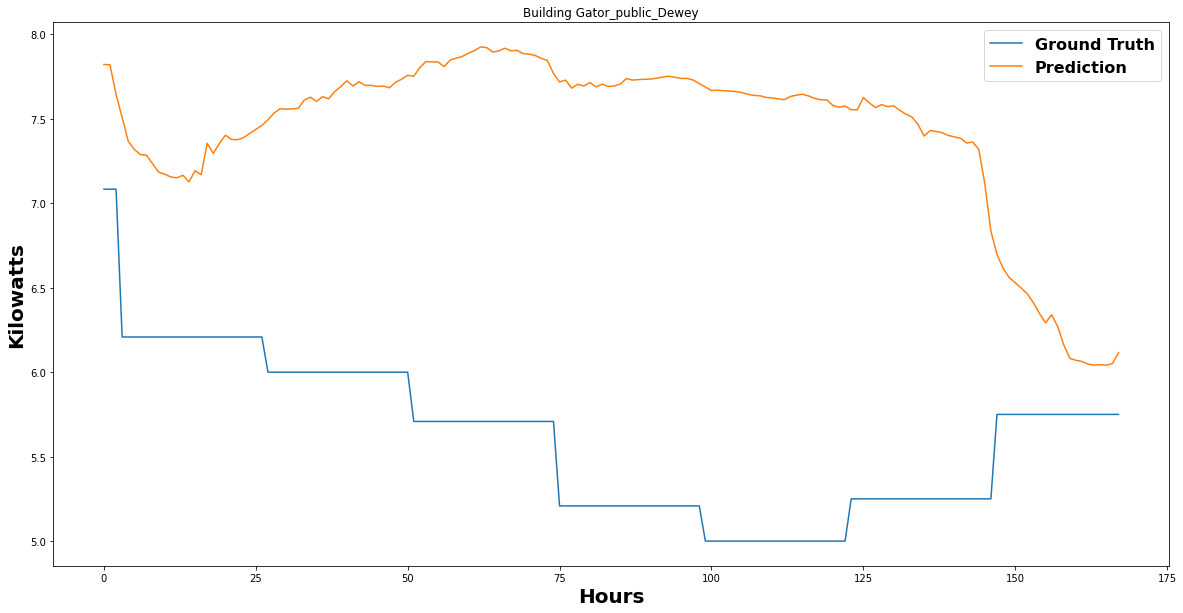

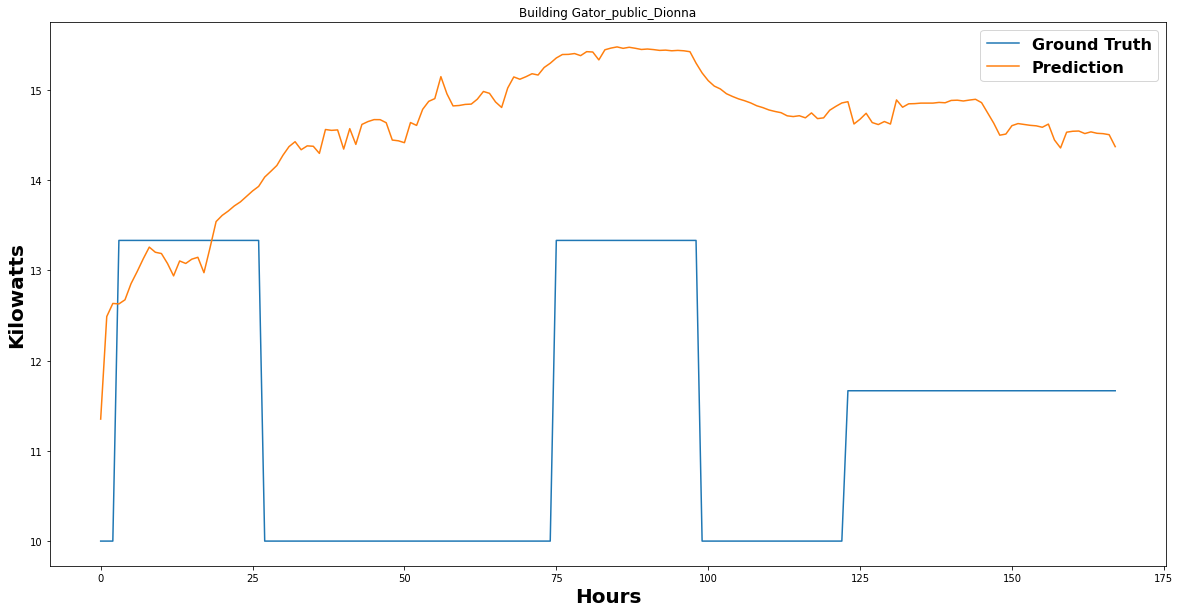

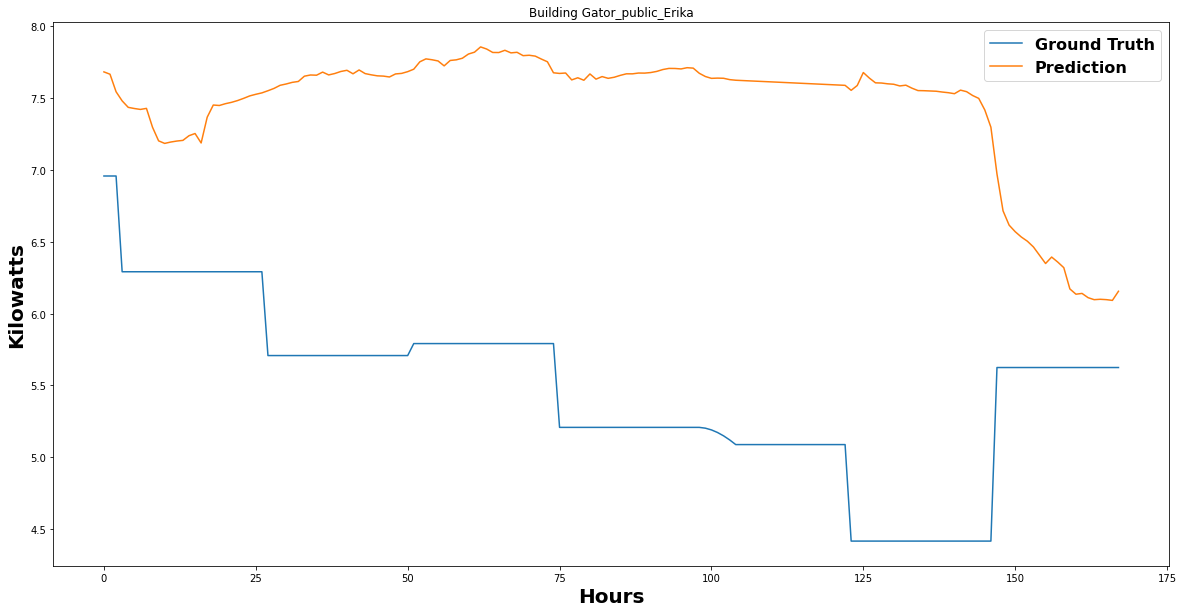

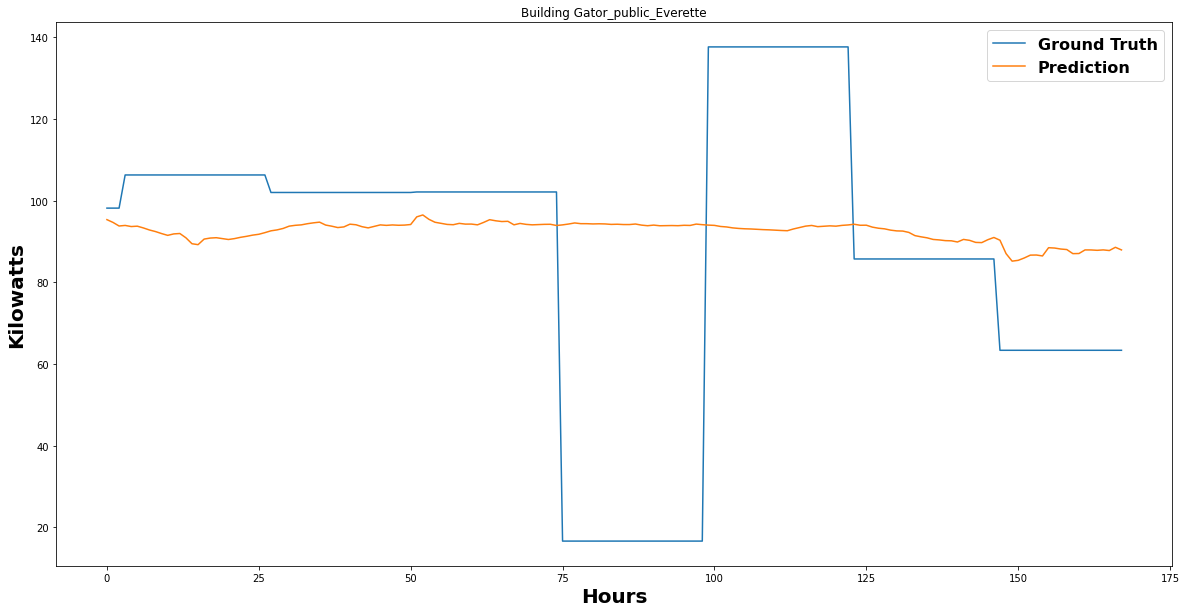

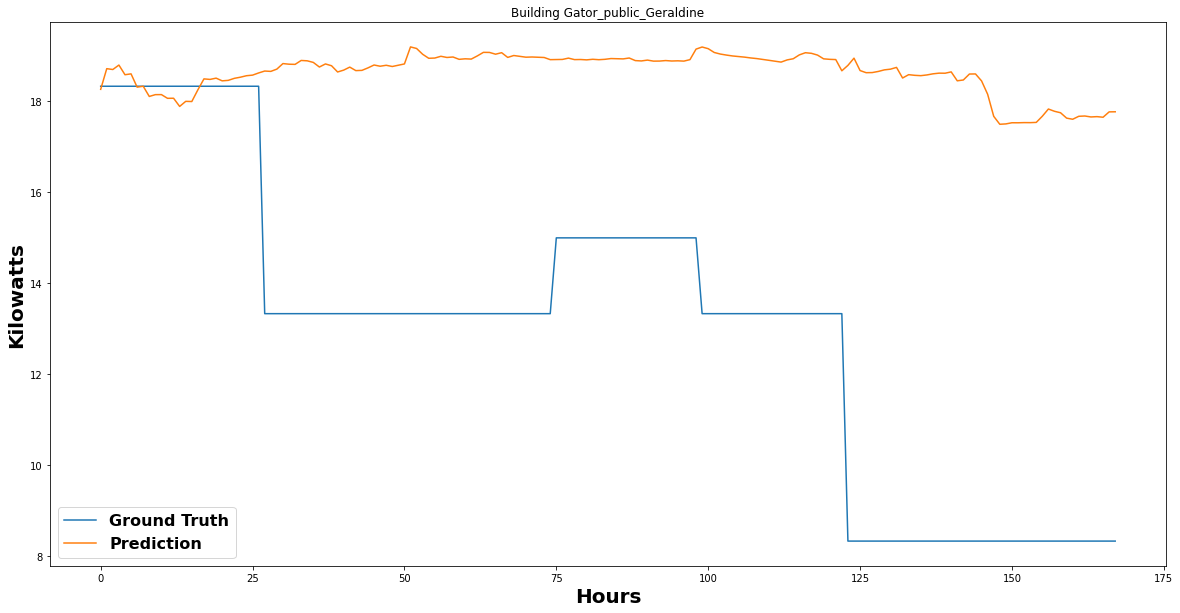

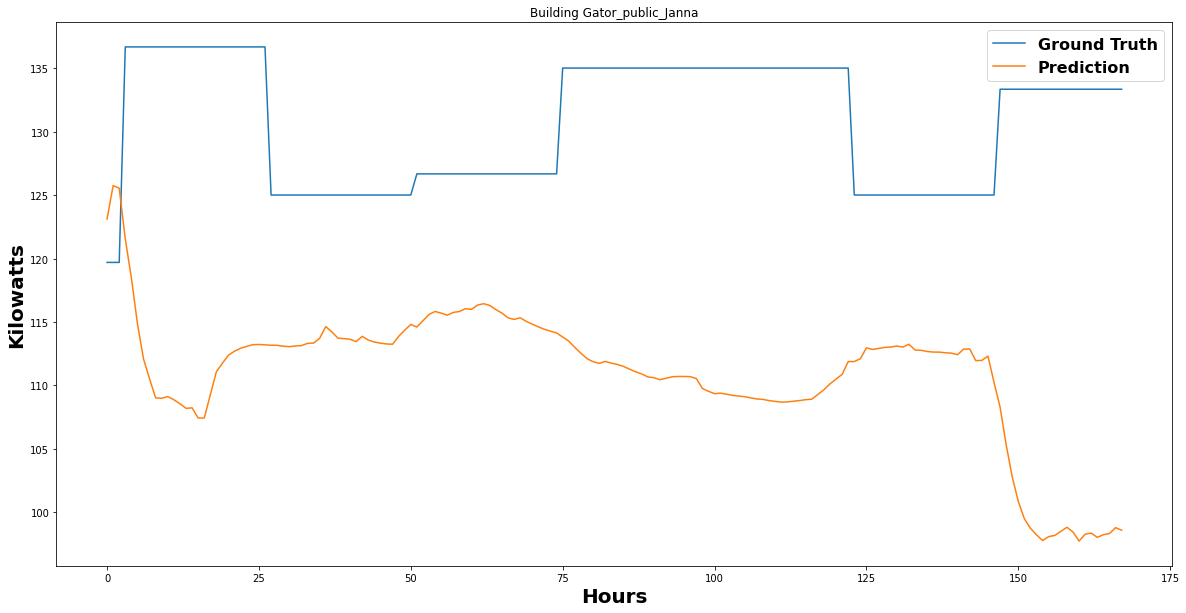

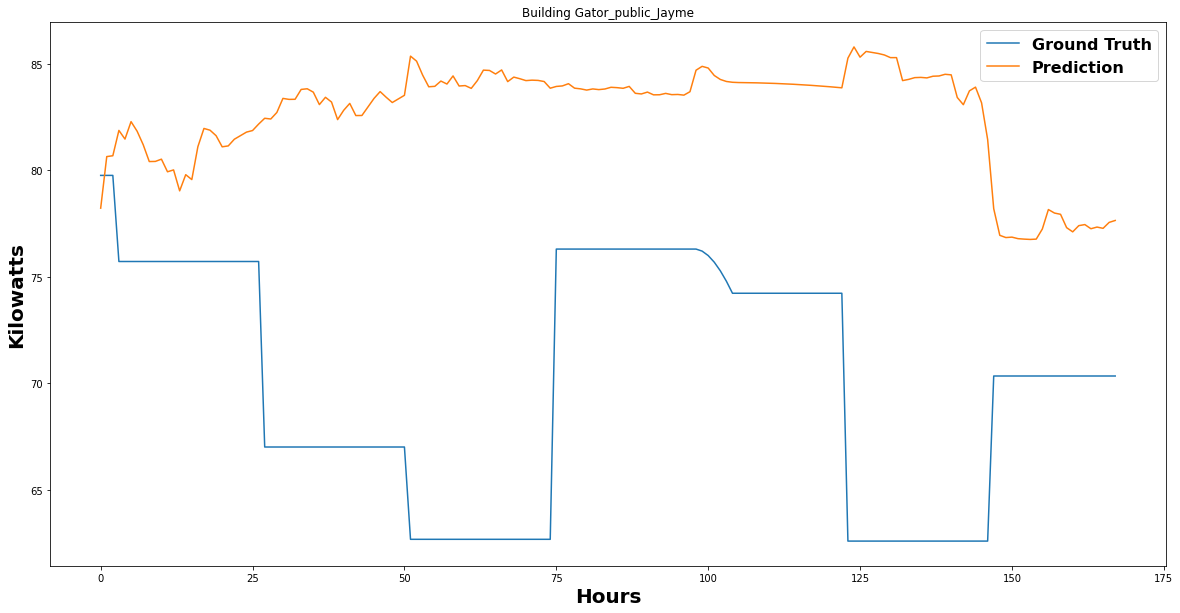

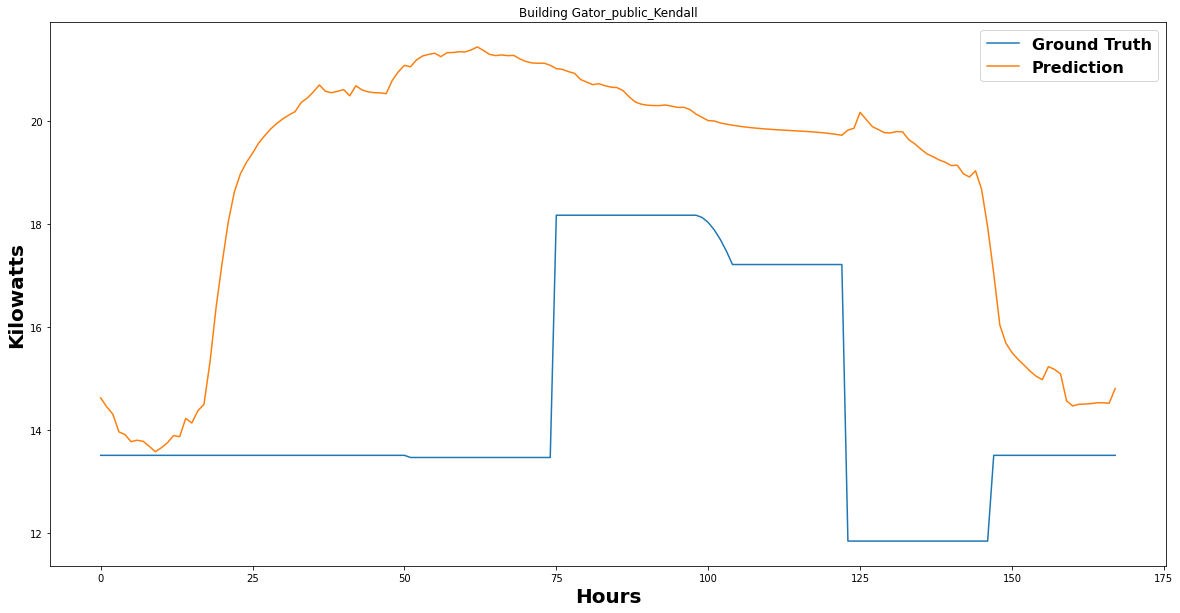

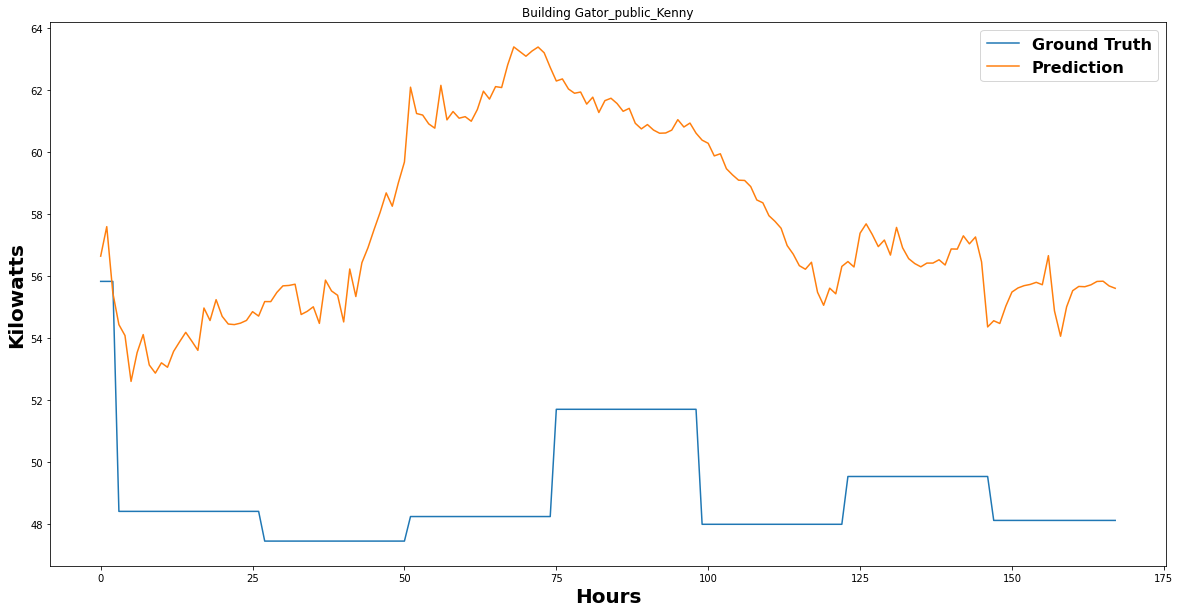

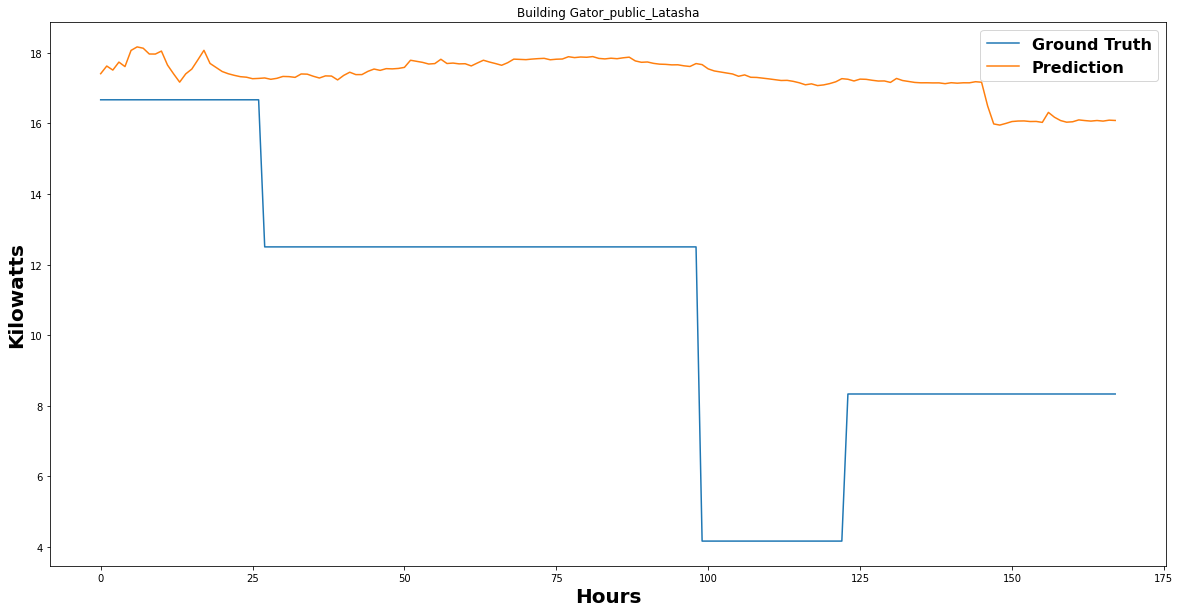

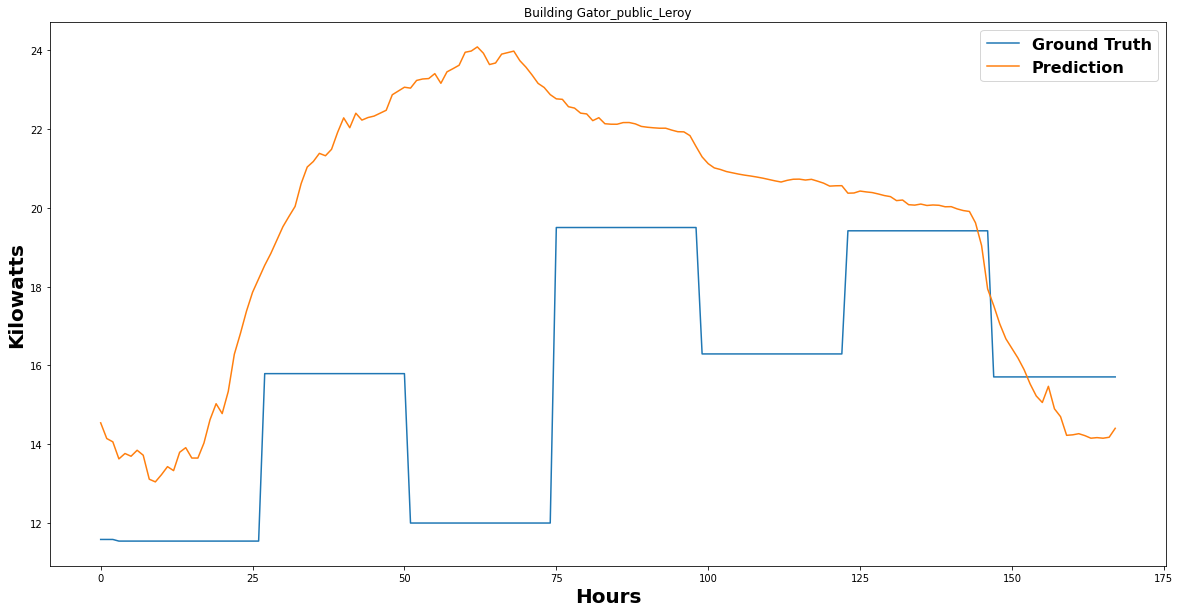

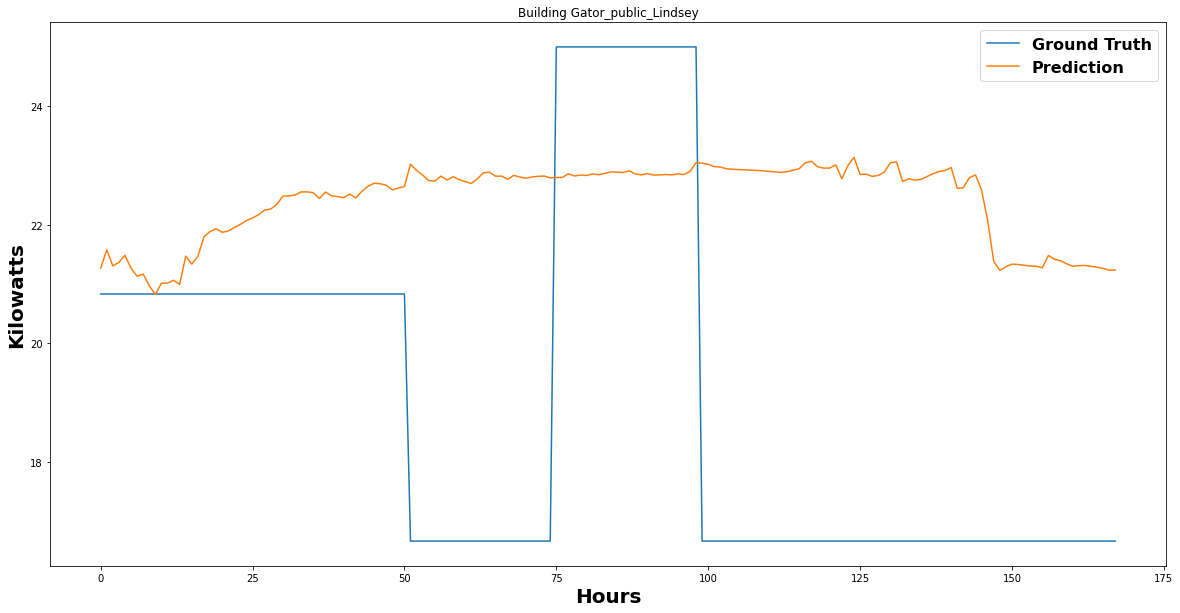

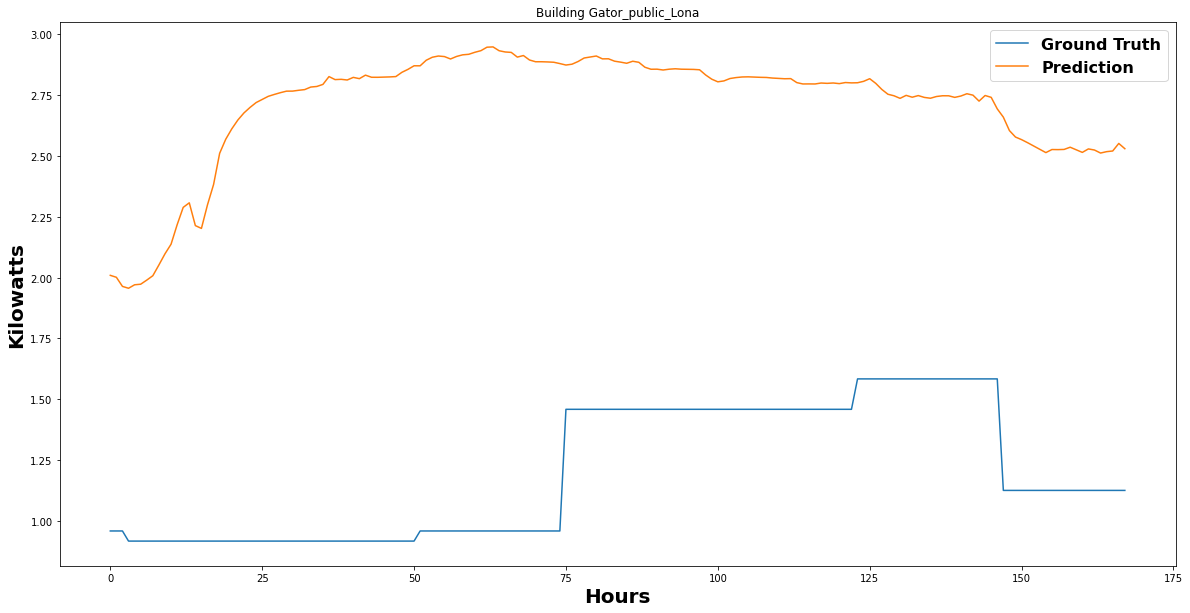

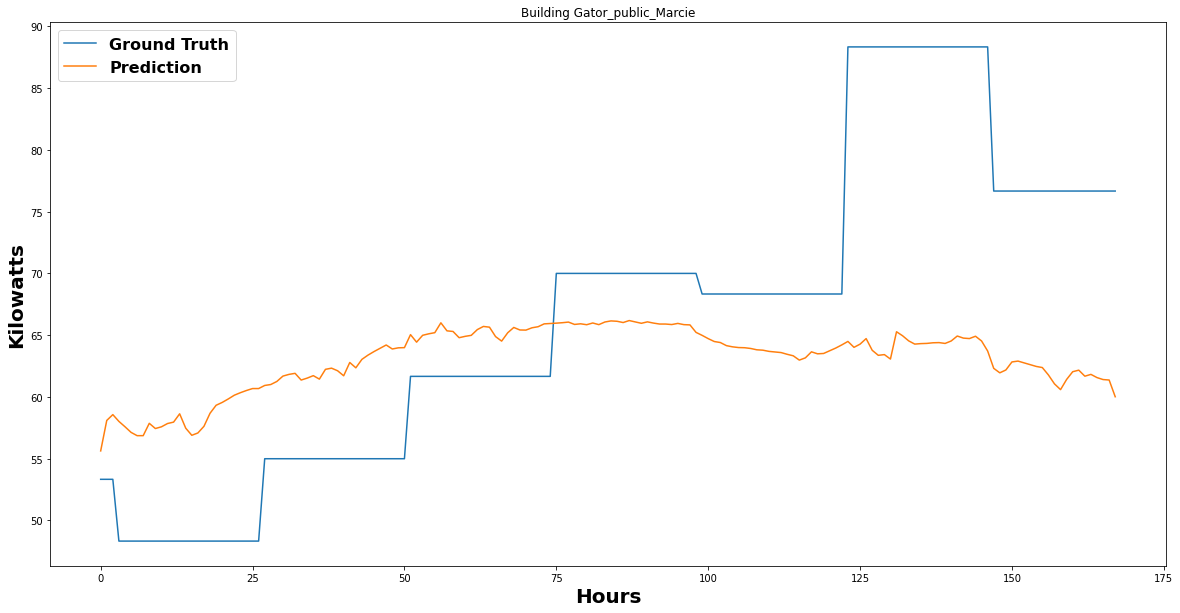

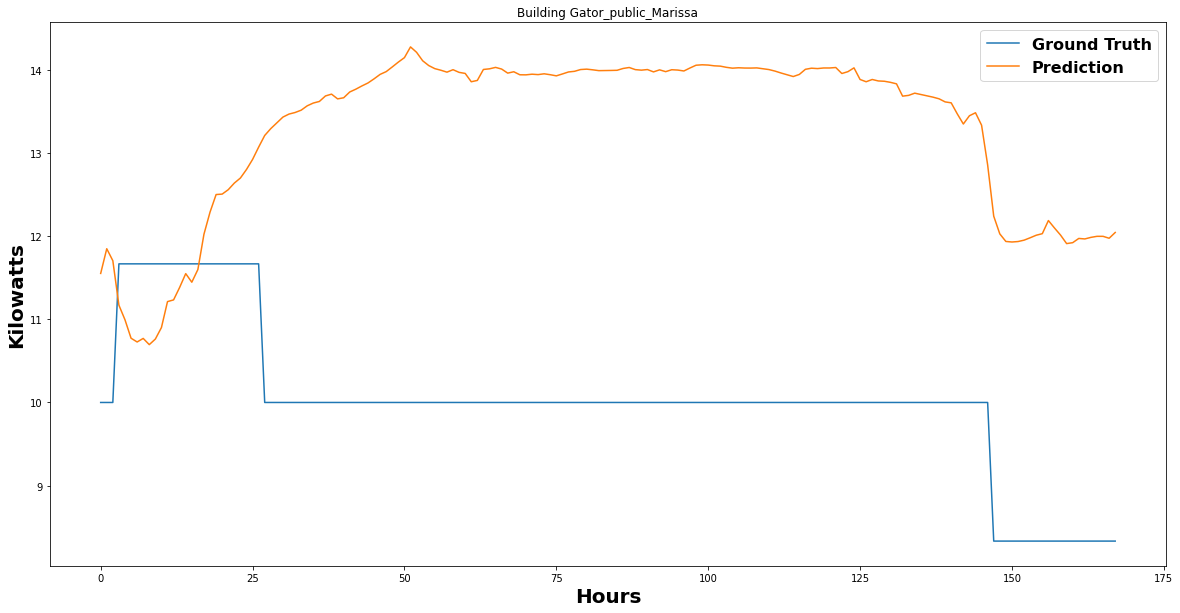

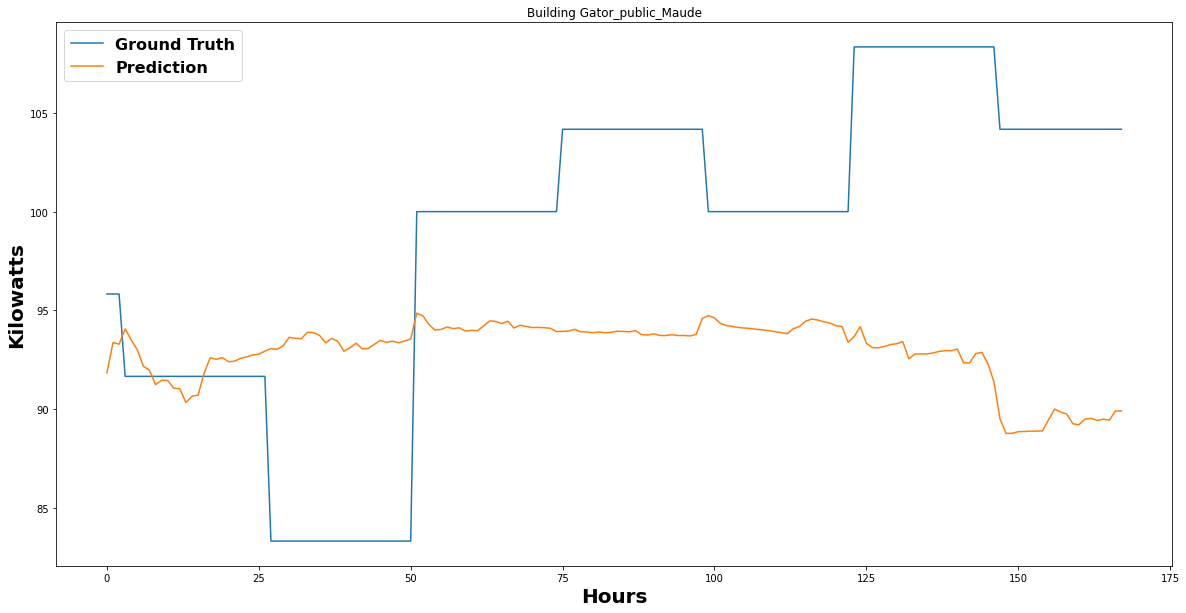

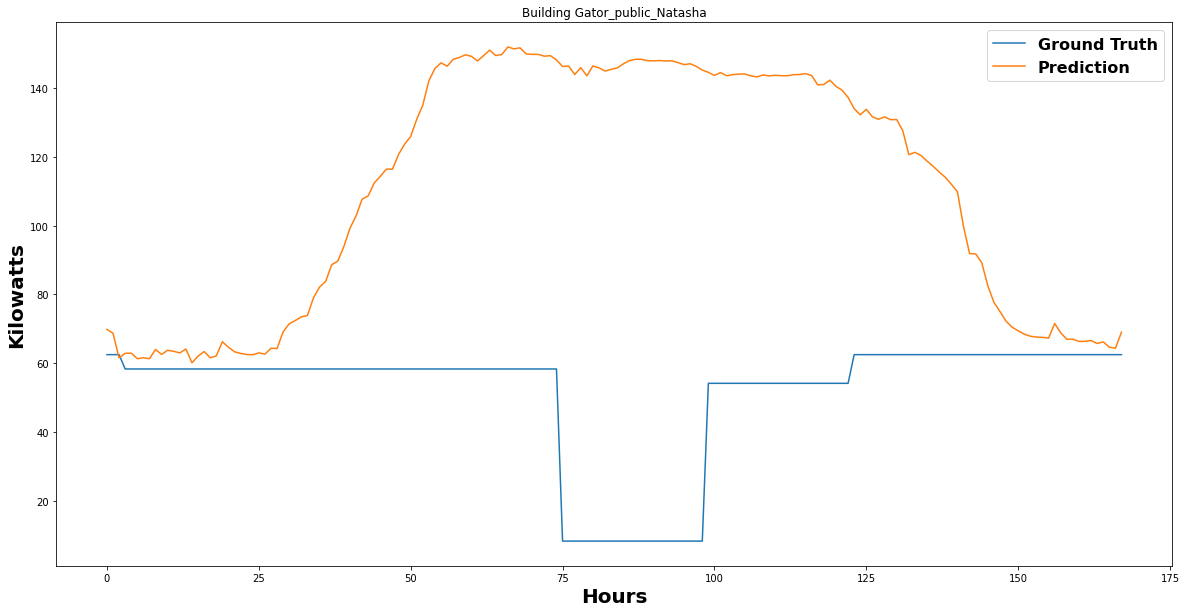

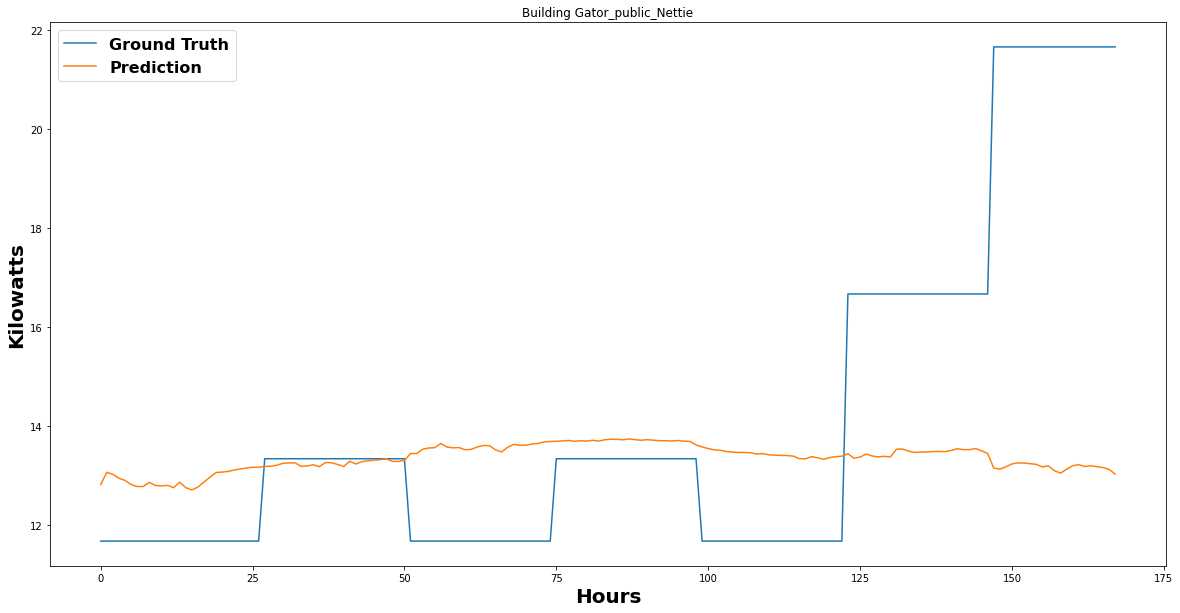

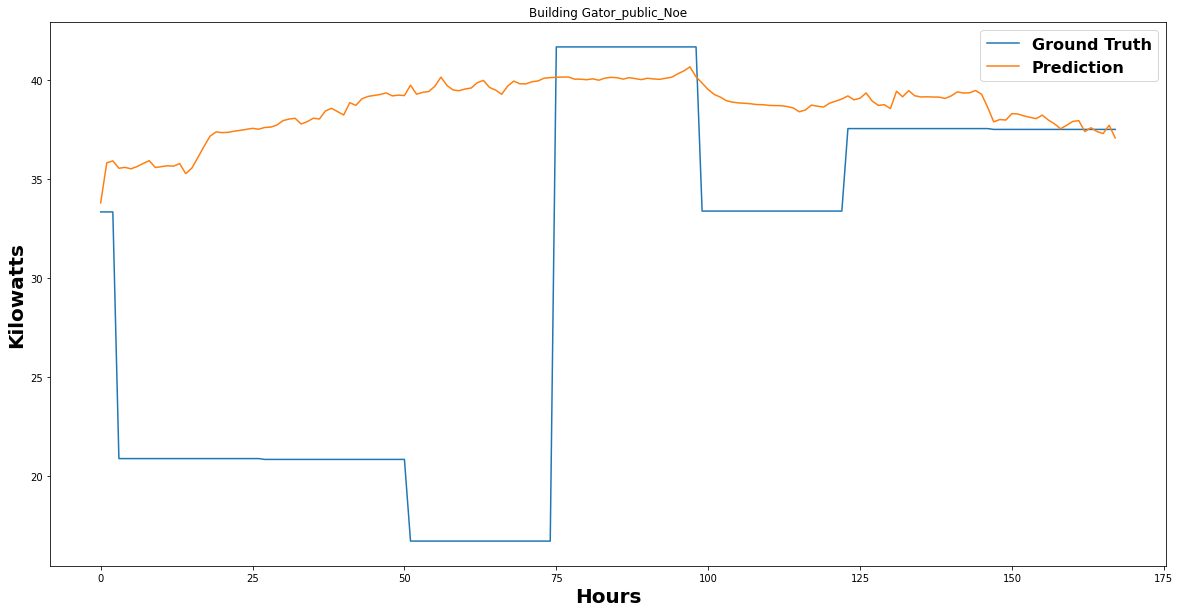

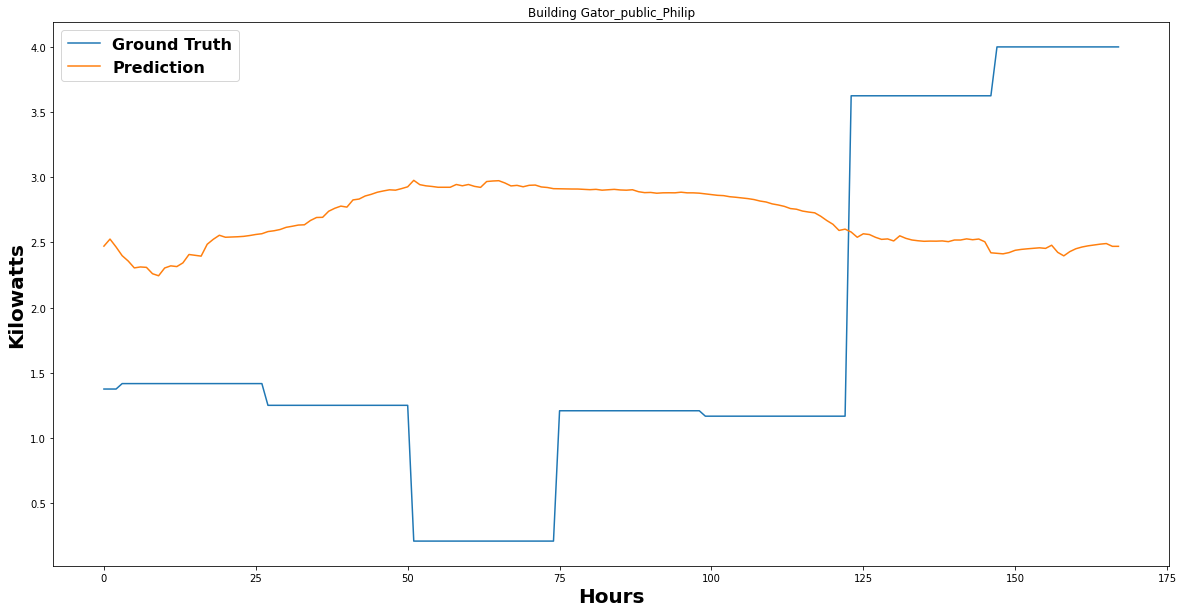

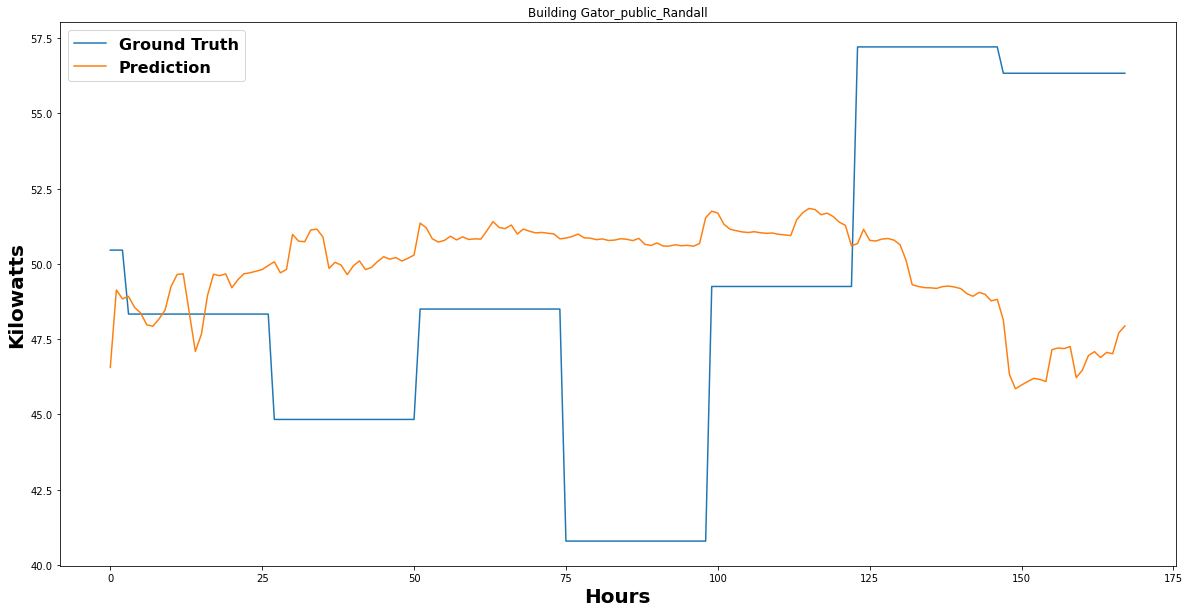

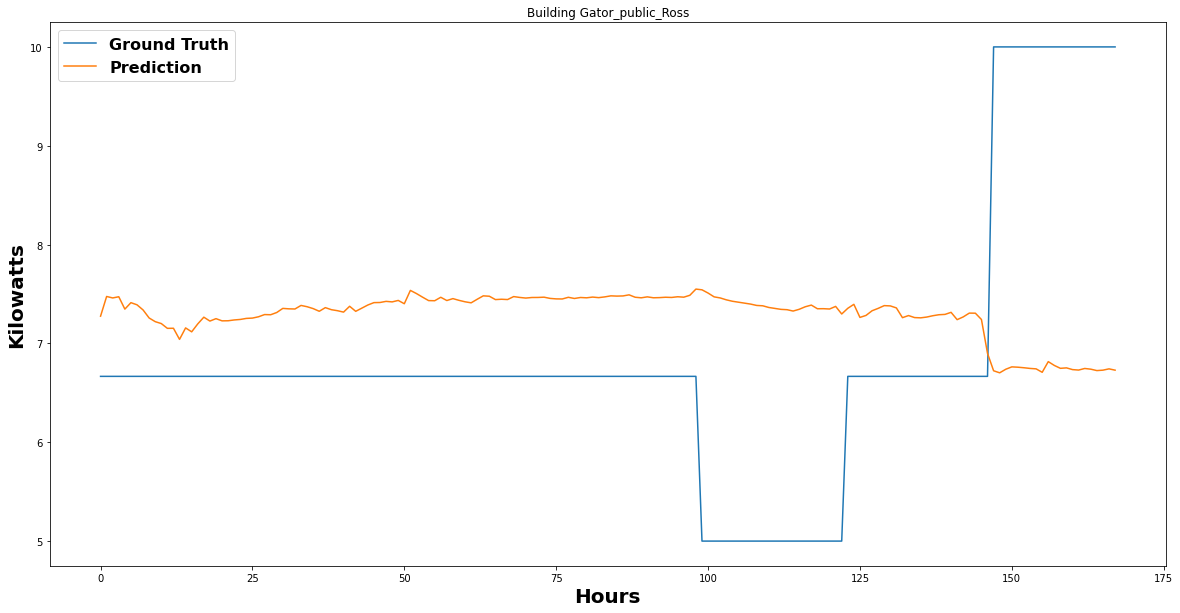

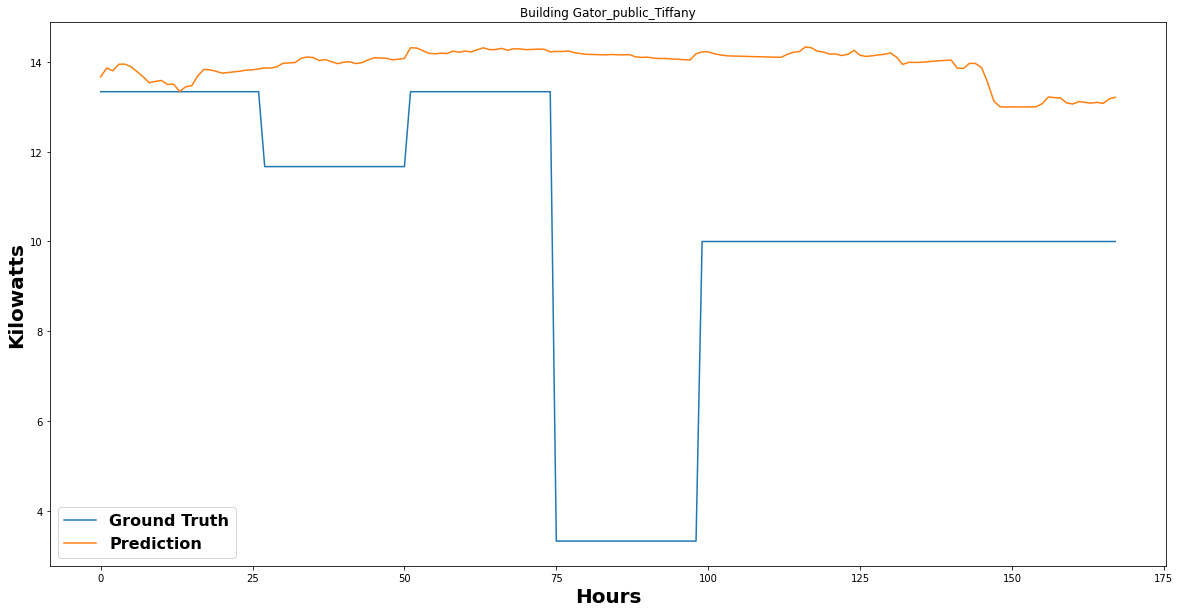

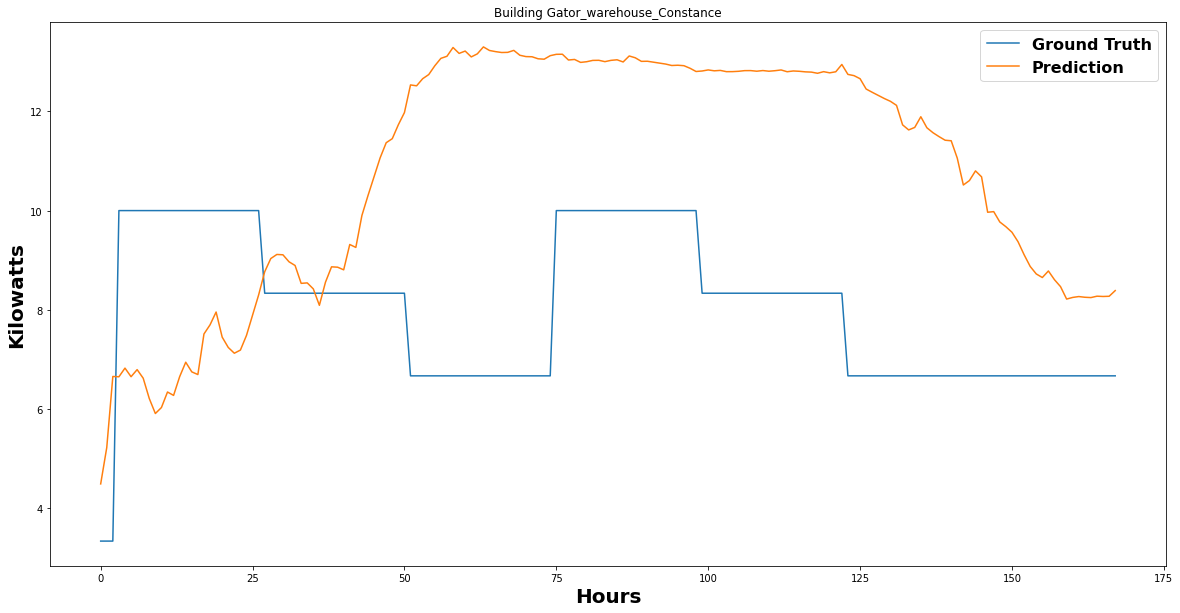

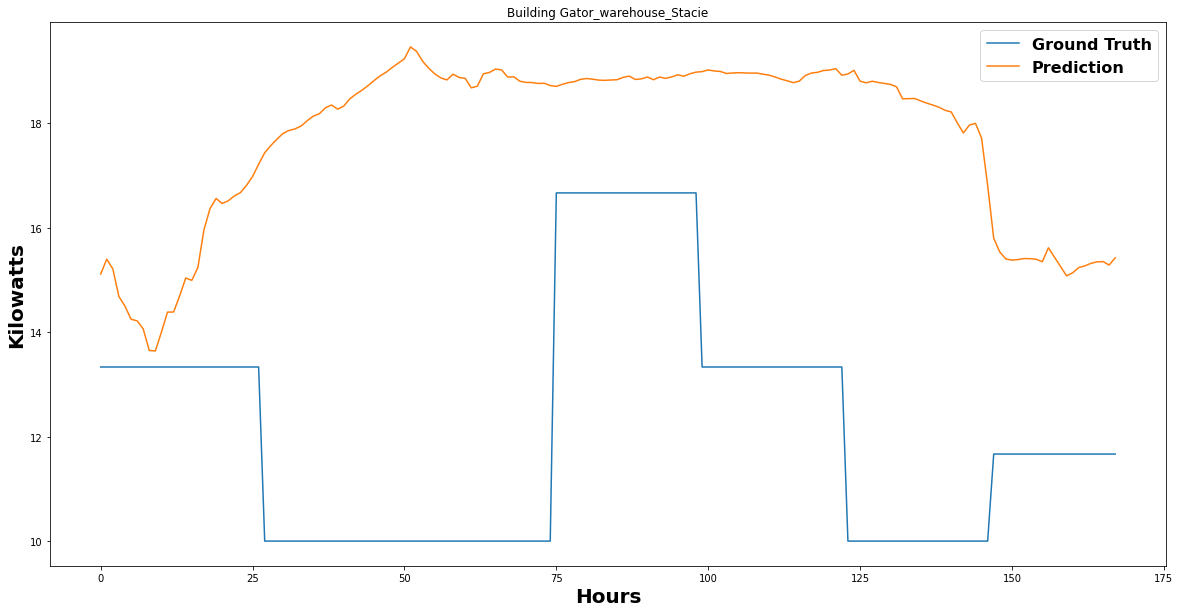

In [22]:
dfs = []
for i in range(n):
    building = buildings[i]
    legend_properties = {'weight':'bold','size':'16'}
    fig, ax = plt.subplots(figsize = (20,10))
    ax.plot(actuals[i], label = "Ground Truth")
    ax.plot(predictions[i], label = "Prediction")
    ax.set_xlabel('Hours', fontsize=20, fontweight='bold')
    ax.set_ylabel('Kilowatts', fontsize=20, fontweight='bold')
    ax.set_title(f"Building {building}") 
    ax.legend(loc = 0, prop = legend_properties)
    plt.show()

    timestamp = val[val.building_id == buildings[i]]["timestamp"][-168:]
    building_id = val[val.building_id == buildings[i]]["building_id"][-168:]
    electricity = val[val.building_id == buildings[i]]["electricity"][-168:]
    df = pd.DataFrame(data = dict(timestamp=timestamp , building_id=building_id, electricity=electricity))
    df["predictions"] = predictions[i]
    df = df.reset_index(drop = True)
    dfs.append(df)

In [23]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

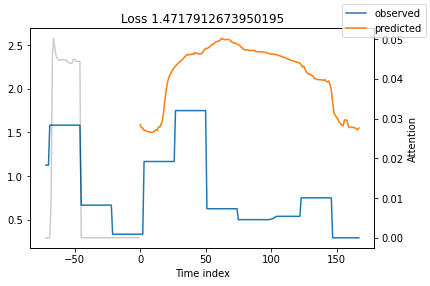

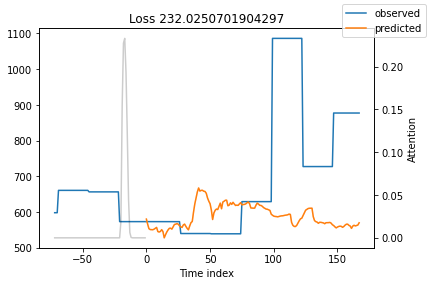

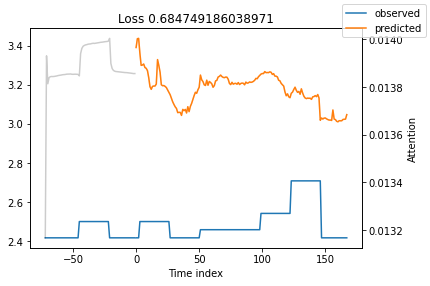

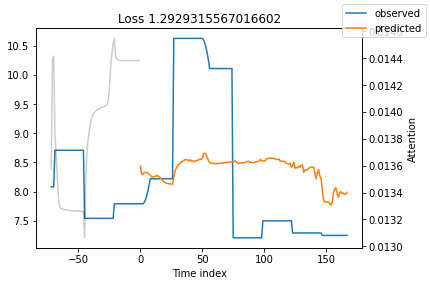

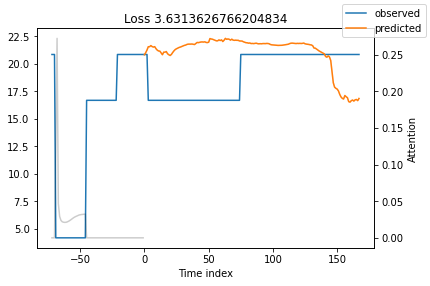

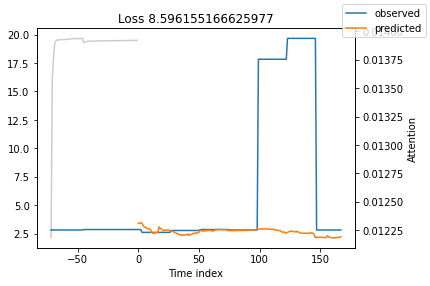

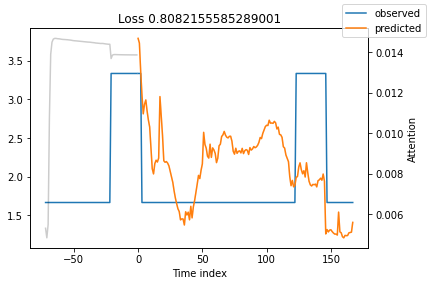

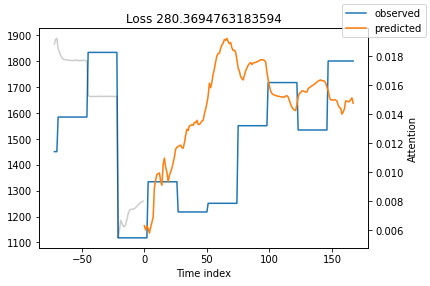

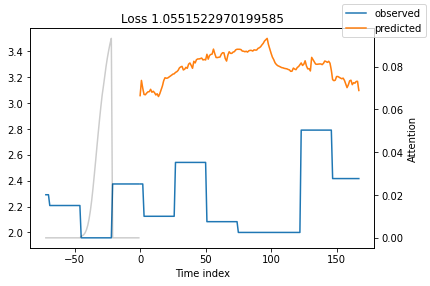

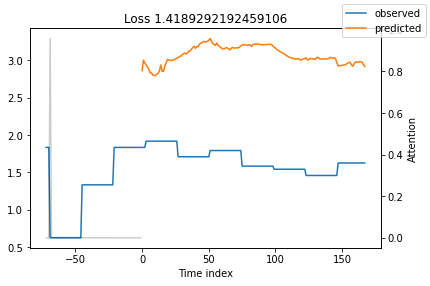

In [24]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

c:\Users\nmert\OneDrive\Data Science\OMSA\HW & Projects\omsa_dva_project\.venv\lib\site-packages\pytorch_forecasting\models\base_model.py:1666: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(**kwargs)


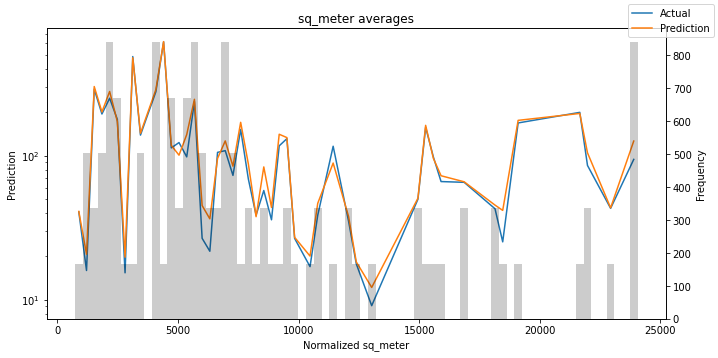

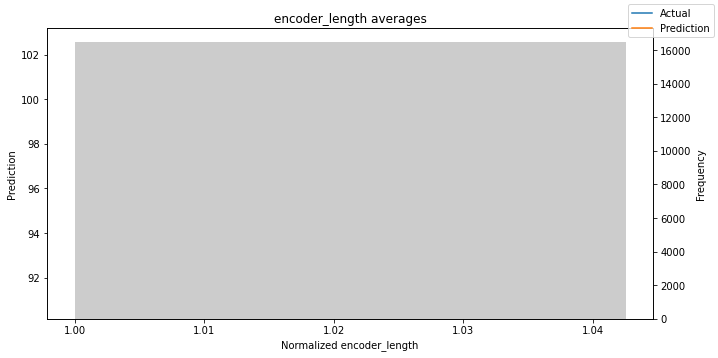

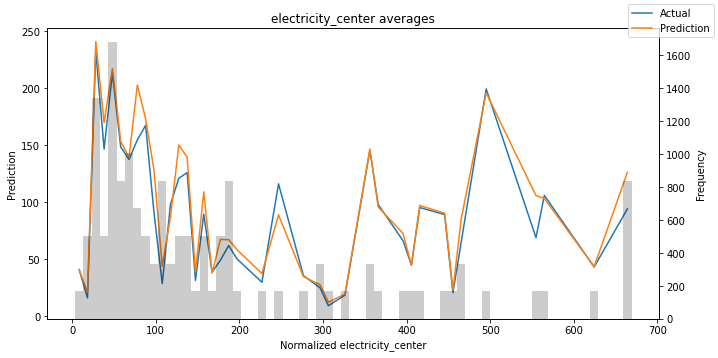

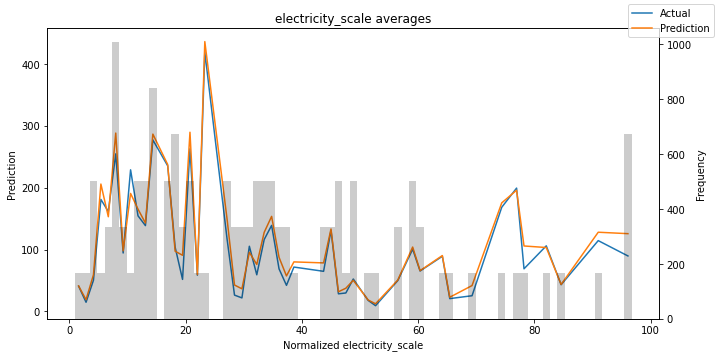

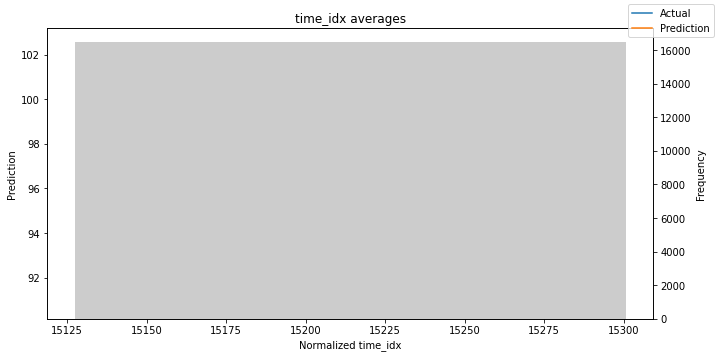

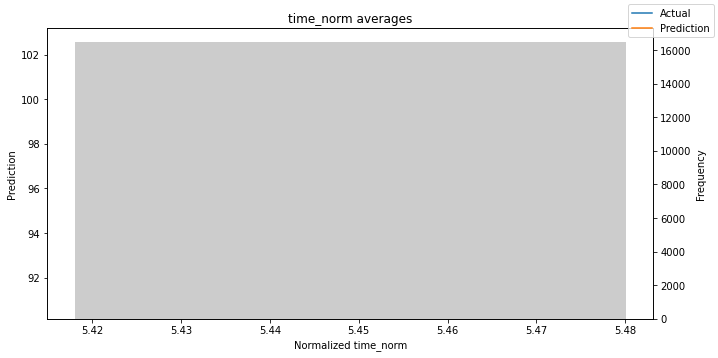

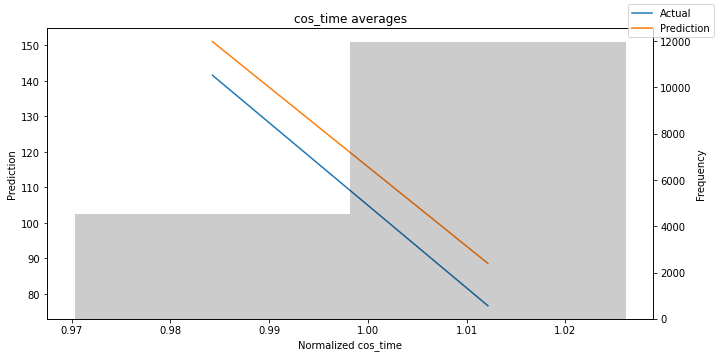

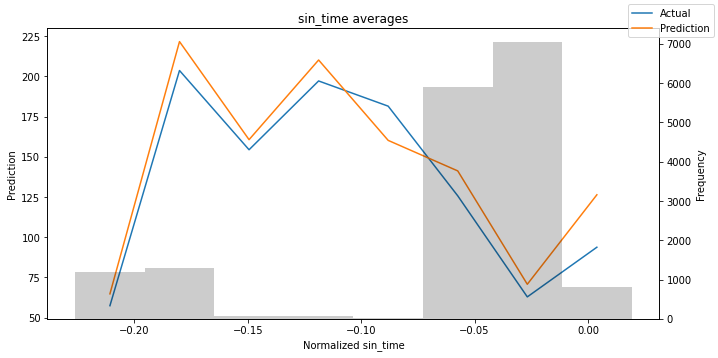

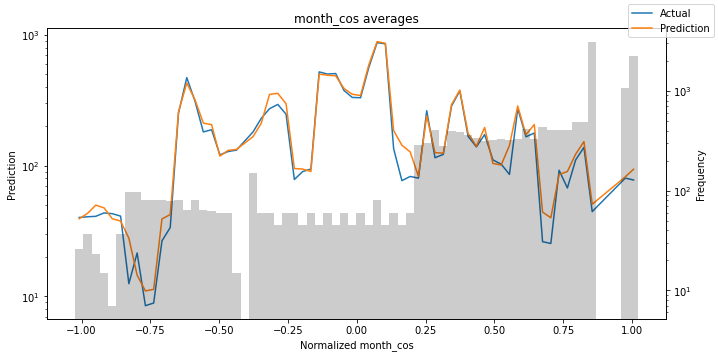

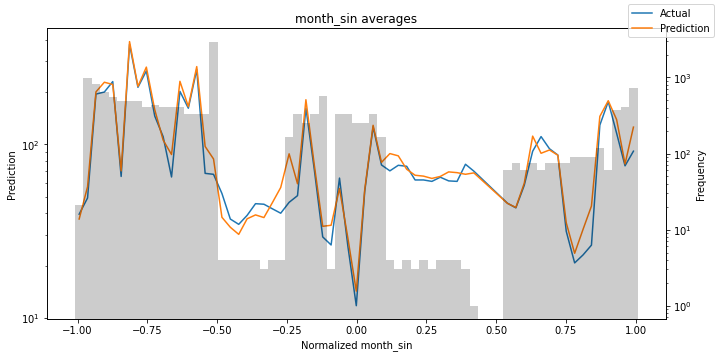

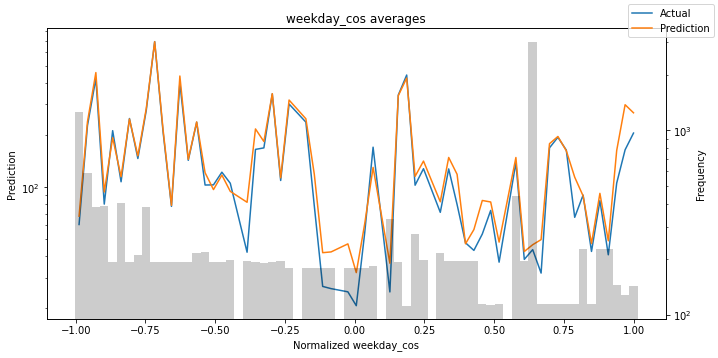

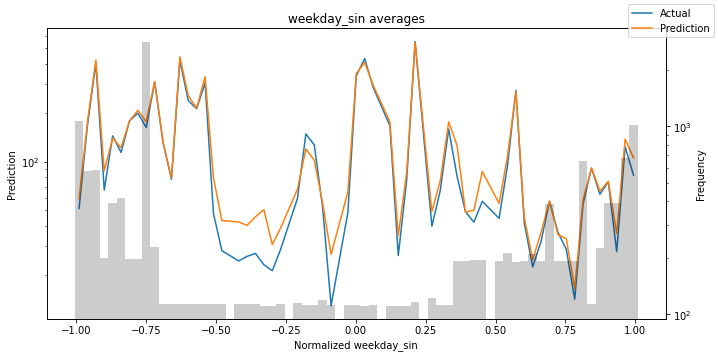

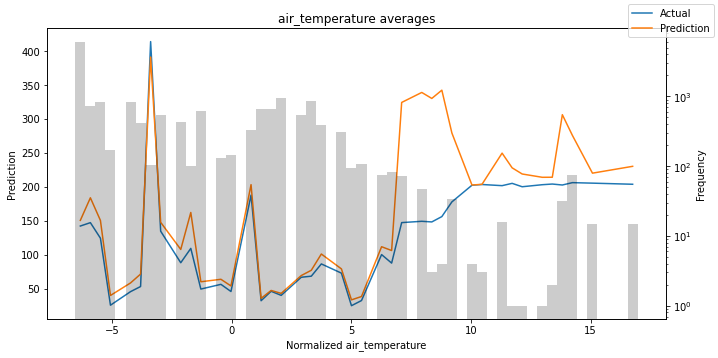

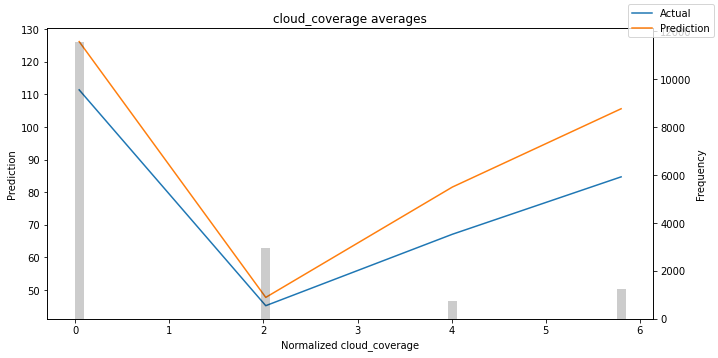

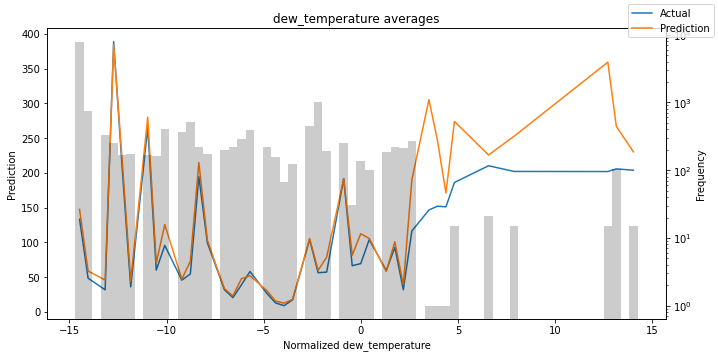

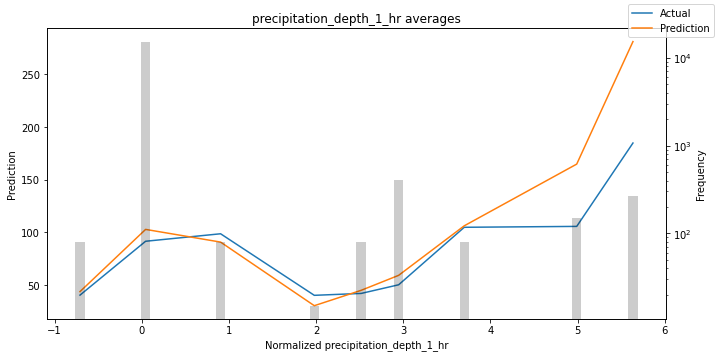

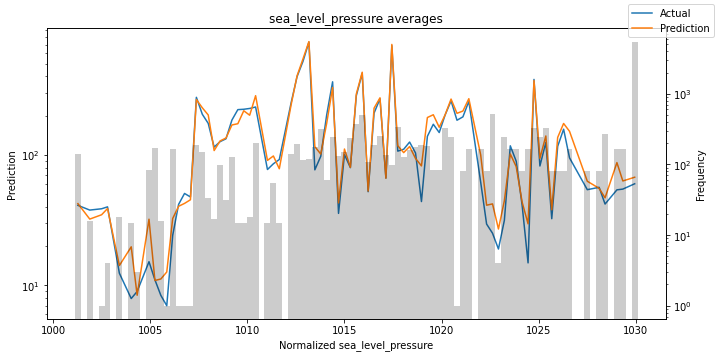

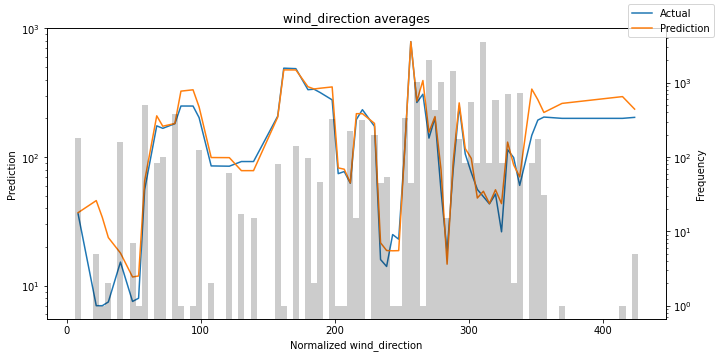

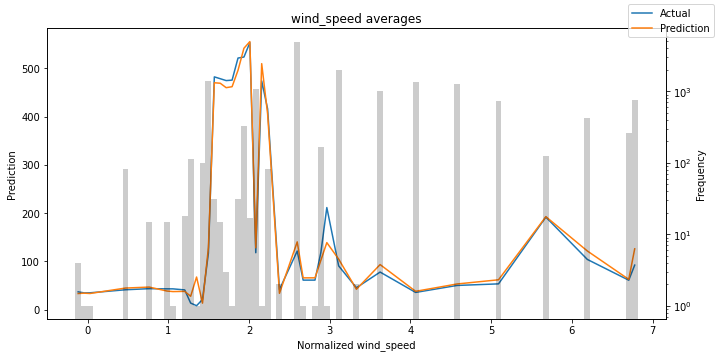

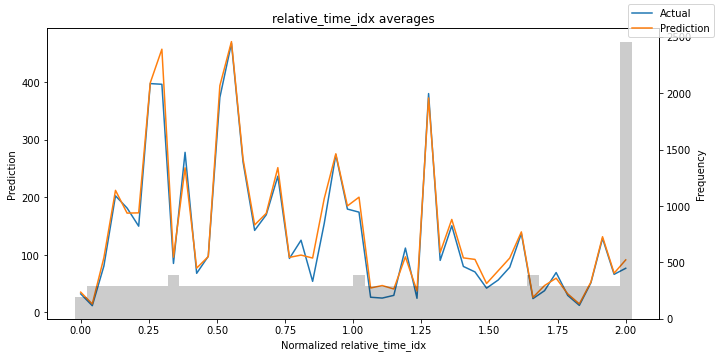

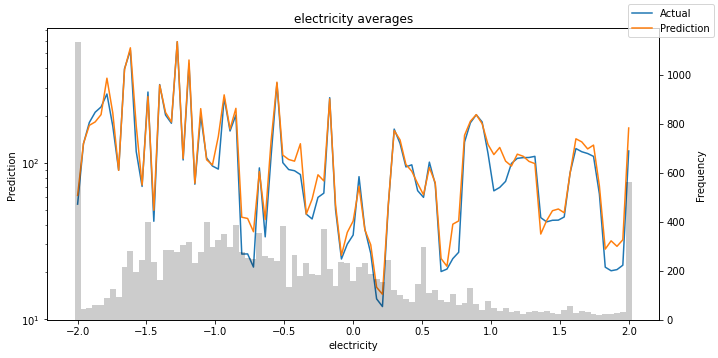

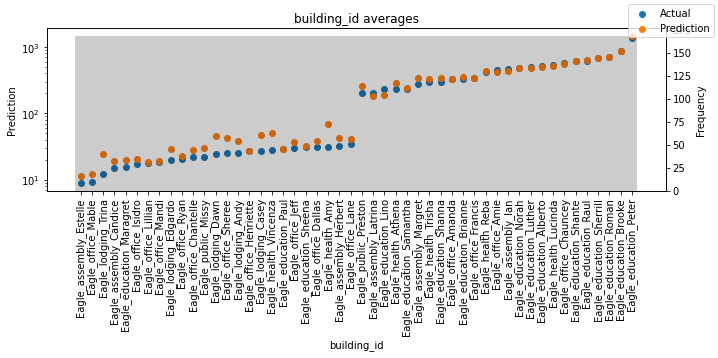

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x234 with 1 Axes>,
 'encoder_variables': <Figure size 504x450 with 1 Axes>,
 'decoder_variables': <Figure size 504x432 with 1 Axes>}

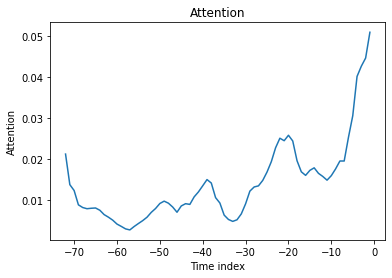

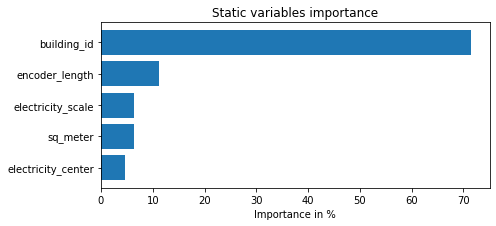

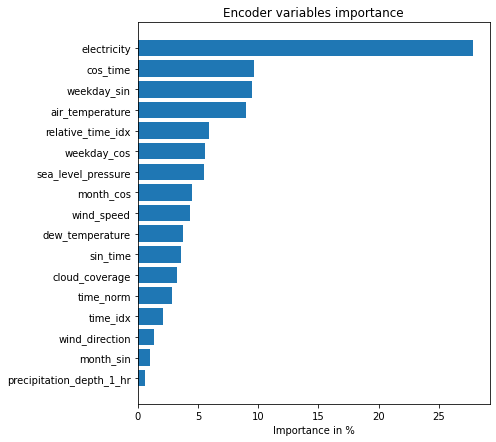

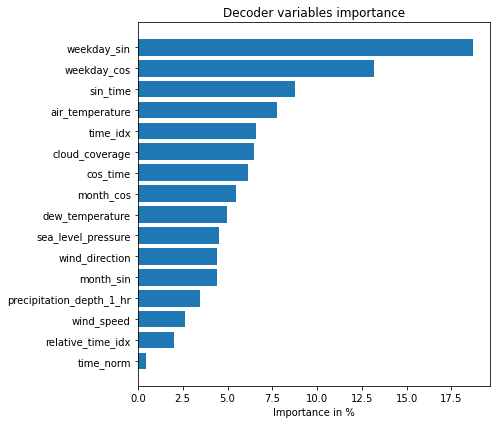

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [26]:
# Save model results:
results = pd.concat(dfs)
directory = f"forecasting/results"
file_name = f"{site}.parq"

results.to_parquet(path = file_name, engine = "pyarrow", compression = "gzip", index = False)
storage.upload(file_system, directory = directory, file_name = file_name, file_path = file_name, overwrite=True)

Gator.parq write complete


In [27]:
results

timestamp             building_id  electricity  predictions
0   2017-12-24 03:00:00   Gator_assembly_Bailey       0.3333     1.589373
1   2017-12-24 04:00:00   Gator_assembly_Bailey       0.3333     1.553834
2   2017-12-24 05:00:00   Gator_assembly_Bailey       0.3333     1.551421
3   2017-12-24 06:00:00   Gator_assembly_Bailey       0.3333     1.521859
4   2017-12-24 07:00:00   Gator_assembly_Bailey       0.3333     1.524199
..                  ...                     ...          ...          ...
163 2017-12-31 16:00:00  Gator_warehouse_Stacie      11.6667    15.318138
164 2017-12-31 17:00:00  Gator_warehouse_Stacie      11.6667    15.345844
165 2017-12-31 18:00:00  Gator_warehouse_Stacie      11.6667    15.351902
166 2017-12-31 19:00:00  Gator_warehouse_Stacie      11.6667    15.284966
167 2017-12-31 20:00:00  Gator_warehouse_Stacie      11.6667    15.424479

[10752 rows x 4 columns]